In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np #    
import matplotlib
import tkinter

import matplotlib.pyplot as plt #                                                              +                        
import cv2
import ipywidgets as widgets
from PIL import ImageEnhance
from PIL import Image # отрисовка изображений

from skimage import io, color
from skimage import util
from IPython.display import display

import matplotlib.image as mpimg 
import os
from tensorflow.keras.preprocessing import image

import pydicom
from skimage.transform import rotate
from skimage.transform import resize
from skimage import exposure
import tifffile

<h1 style="color:red;">NN_700/15(2) - норма (.tiff)</h1>

<h2 style="color:Navy;">1. Создание заданных проекций (оси X,Y,Z, проходящие через кость, взаимно перпендикулярны)</h2>

<h3 style="color:MidnightBlue;">1.1 Создание трехмерноо массива 'volume152' с проверками и преобразованиями при необходимости</h3>

Проверка наличия атрибута ImagePositionPatient перед его использованием.
Использование альтернативных атрибутов: Если ImagePositionPatient отсутствует, упорядочить файлы на основе других атрибутов, таких как InstanceNumber или SliceLocation

In [45]:
directory = 'D:/AleksandrovTI/NN_700/15(2)'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume152 = np.stack([s[0] for s in slices], axis=-1)
print(volume152.shape)

(512, 512, 974)


<h3 style="color:MidnightBlue;">1.2 Визуализация по стандартным проекцим</h3>

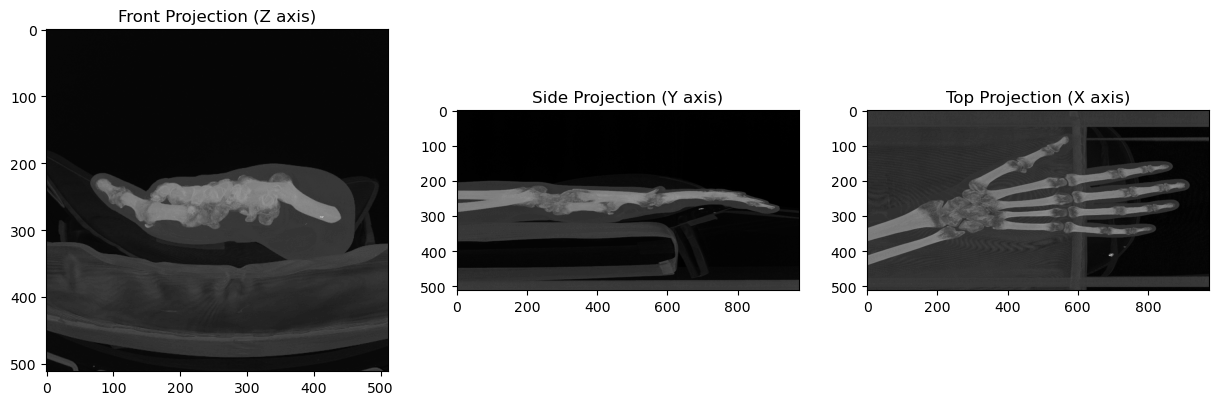

In [46]:
projection_z152 = np.max(volume152, axis=2) # Front projection (по оси Z)
projection_y152 = np.max(volume152, axis=1) # Side projection (по оси Y)
projection_x152 = np.max(volume152, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z152, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y152, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x152, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h3 style="color:MidnightBlue;">1.3 Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ  X</h3>

In [47]:
# Top projection (по оси X)
projection_x152 = np.max(volume152, axis=0)
tifffile.imwrite('01_projection_x152.tiff', projection_x152) # Сохранение массива в TIFF-файл

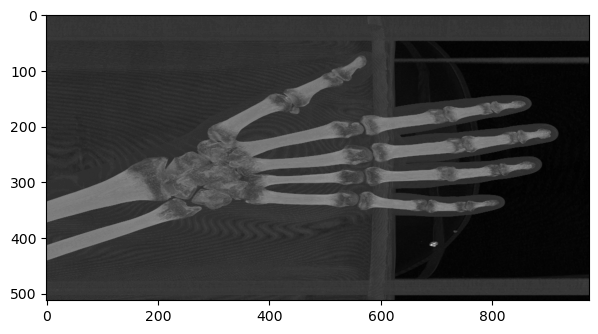

In [48]:
image = tifffile.imread('01_projection_x152.tiff')
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

In [39]:
imagess = tifffile.imread('01_projection_x152.tiff')
imagesss = np.array(imagess)
imagesss.shape

(512, 974)

<h4 style="color:Blue;">1.3.1 Построение угла</h4>

In [77]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('01_projection_x152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f"{angle:.2f} deg", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('02_projection_x152_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: 16.76 градусов
Горизонтальная линия нарисована через точку: (5, 353)
Углы, сохраненные в программе: [16.755748929198983]


In [78]:
print(angle)

16.755748929198983


In [79]:
a1 = angle
a1

16.755748929198983

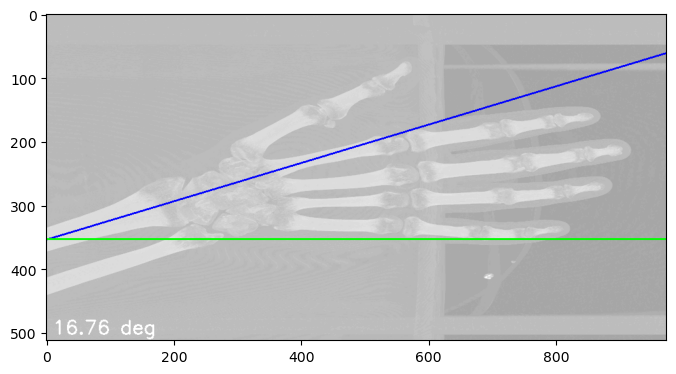

In [80]:
image1 = tifffile.imread('02_projection_x152_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h3 style="color:MidnightBlue;">1.4 Поворот плоскостей вокруг оси Z с заданным углом поворота - получение  'rotated_volume282'</h3>

Original volume shape: (512, 512, 974)
Rotated volume shape: (512, 512, 974)


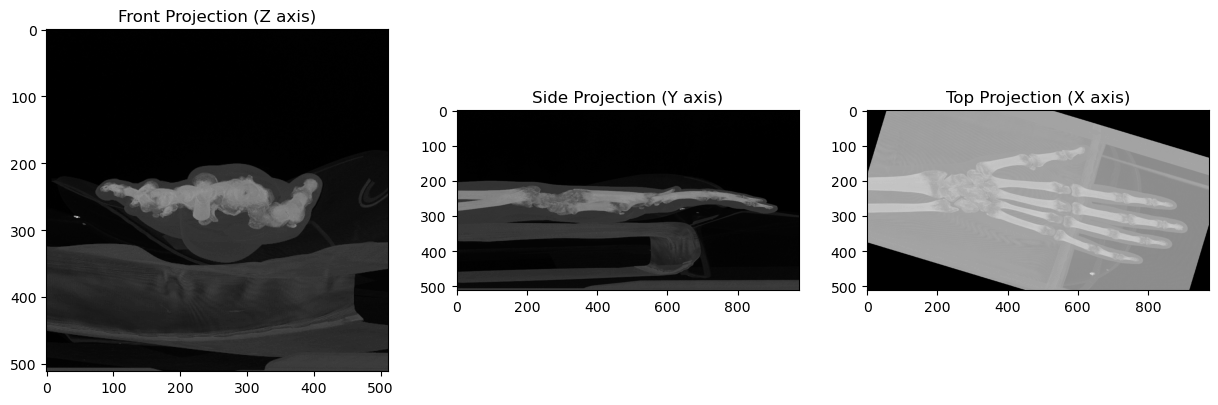

In [81]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'D:/AleksandrovTI/NN_700/15(2)'

# Чтение и нормализация изображения
volume = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume.shape)

# Угол поворота 
angle = a1

# Поворот объёма вокруг оси Z
rotated_volume152 = rotate_volume(volume, angle)
print("Rotated volume shape:", rotated_volume152.shape)

# Получение проекций после поворота
projection_xr, projection_yr, projection_zr = get_projections(rotated_volume152)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


<h3 style="color:MidnightBlue;">1.5 Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ Y</h3>

In [82]:
# Side Projection (Y axis)
projection_yr152 = np.max(rotated_volume152, axis=1)
projection_yr152 = np.flip(projection_yr152, axis=1) # ИСПРАВЛЕНИЕ ВЫВОДА ЗЕРКАЛЬНОГО ИЗОБРАЖЕНИЯ
tifffile.imwrite('03_projection_yr152.tiff', projection_yr152)

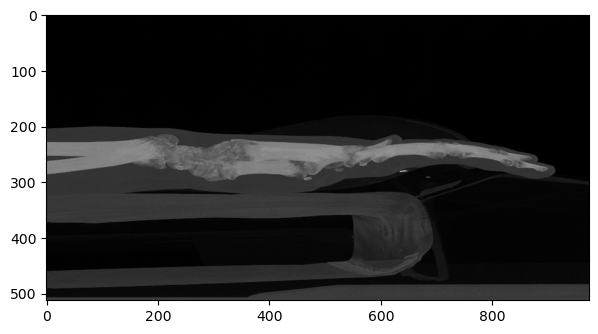

In [83]:
image = tifffile.imread('03_projection_yr152.tiff')
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Blue;">1.5.1 Построение угла</h4>

In [84]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('03_projection_yr152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f"{angle:.2f} deg", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('04_projection_yr152_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: -1.70 градусов
Горизонтальная линия нарисована через точку: (12, 241)
Углы, сохраненные в программе: [-1.701354605326124]


In [85]:
angle

-1.701354605326124

In [86]:
b1 = angle
b1

-1.701354605326124

In [87]:
a1

16.755748929198983

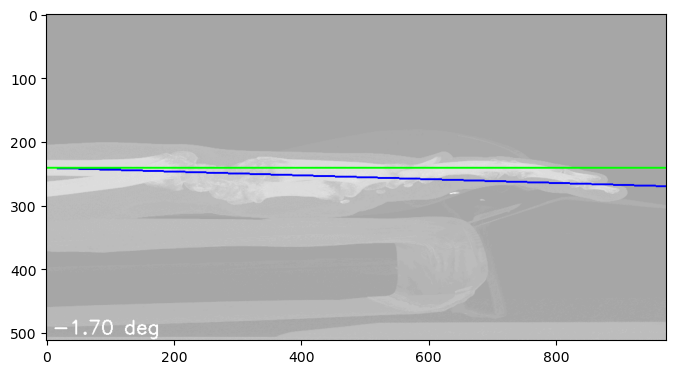

In [88]:
image1 = tifffile.imread('04_projection_yr152_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h3 style="color:MidnightBlue;">1.6 Поворот плоскостей вокруг оси Y с заданным углом поворота - получение  'twice_rotated_volume152'</h3>

Rotated volume shape: (512, 512, 974)


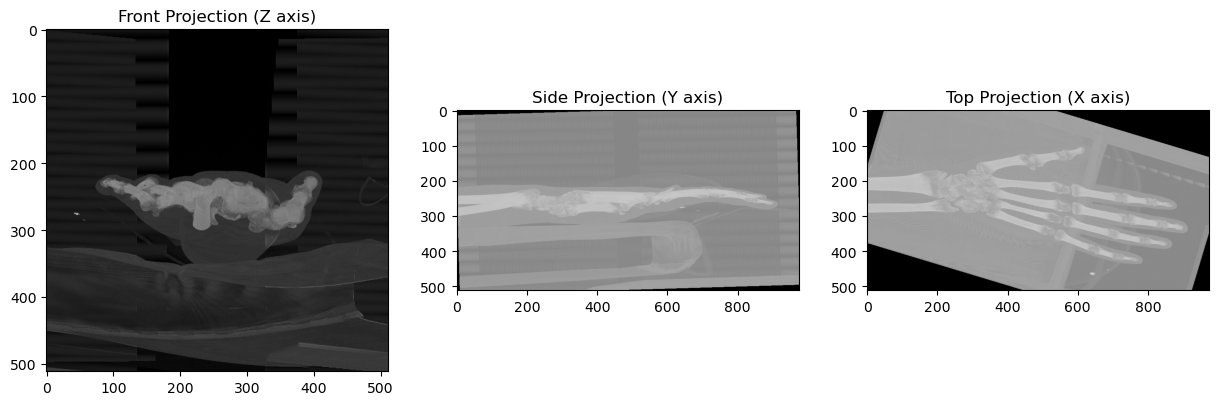

In [89]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xxx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yyy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zzz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xxx, projection_yyy, projection_zzz

# Угол поворота 
angle = b1

# Поворот объёма вокруг оси Y
twice_rotated_volume152 = rotate_volume(rotated_volume152, angle)
print("Rotated volume shape:", twice_rotated_volume152.shape)

# Получение проекций после ВТОРОГО поворота
projection_xrr, projection_yrr, projection_zrr = get_projections(twice_rotated_volume152)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zrr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yrr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xrr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


<h3 style="color:MidnightBlue;">1.7 Вывод проекции Х в twice_rotated_volume152 и определения ВЕРТИКАЛЬНОЙ координаты сечения массива</h3>

In [90]:
projection_xrr152 = np.max(twice_rotated_volume152, axis=0)
projection_xrr152 = np.flip(projection_xrr152, axis=1)
tifffile.imwrite('05_projection_xrr152.tiff', projection_xrr152)

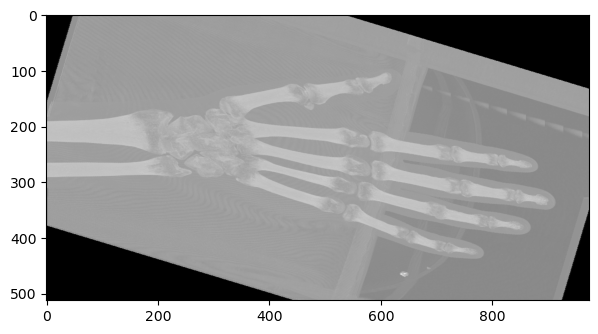

In [91]:
# Отображение изображения
image = tifffile.imread('05_projection_xrr152.tiff')
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Blue;">1.7.1 Определениt ВЕРТИКАЛЬНОЙ координаты сечения  массива</h4>

In [92]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('05_projection_xrr152.tiff')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (130, 209)


<h4 style="color:Blue;">1.7.2 Изображение с ценой деления 10 для уточнения координаты</h4>

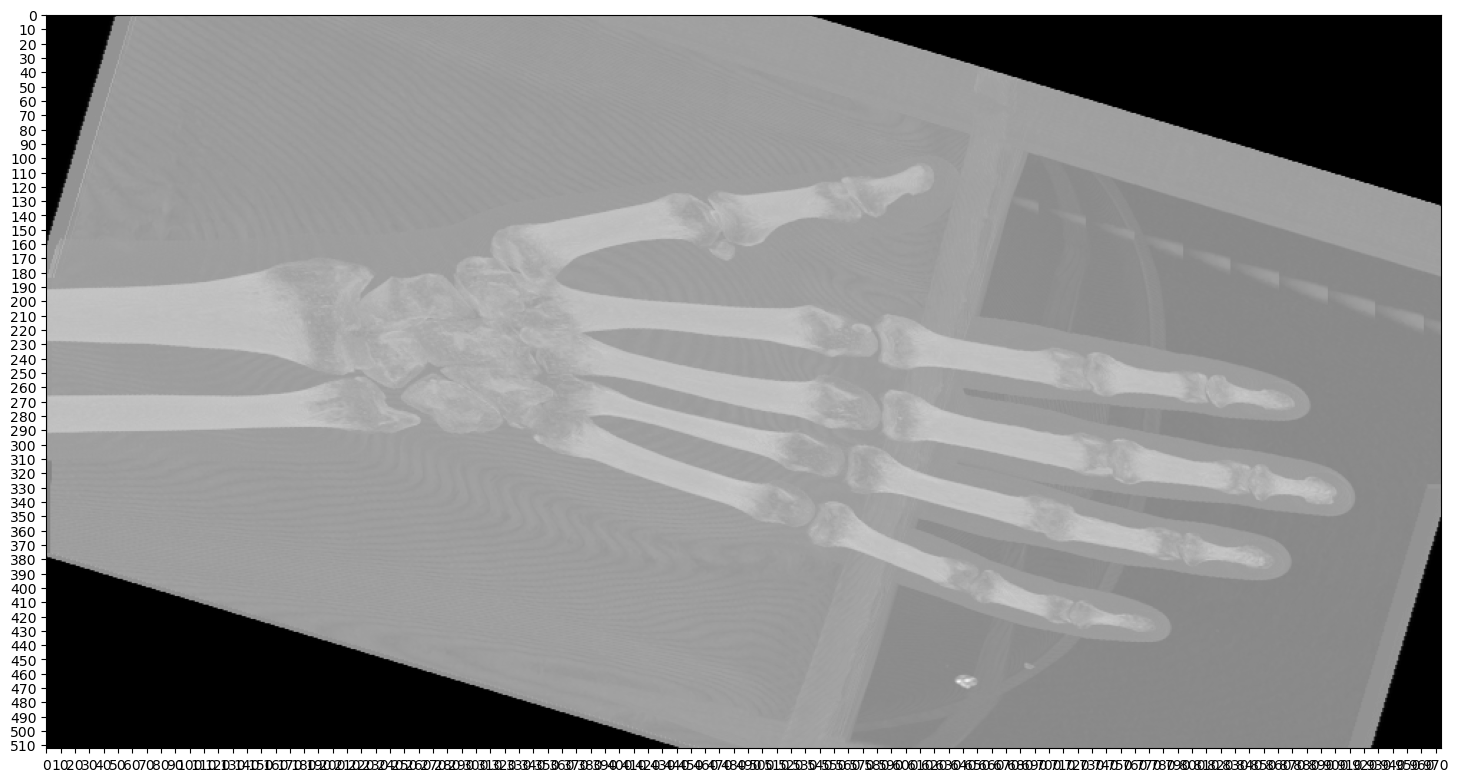

In [93]:
gray_image = mpimg.imread('05_projection_xrr152.tiff')

# Создание фигуры и осей
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(18, 12))  # Увеличенный размер холста
# Отображение изображения
ax.imshow(gray_image, cmap='gray', extent=[0, gray_image.shape[1], gray_image.shape[0], 0])

# Настройка тиков по осям x и y с шагом 20
ax.set_xticks(np.arange(0, gray_image.shape[1], 10))
ax.set_yticks(np.arange(0, gray_image.shape[0], 10))

# Показ графика
plt.show()

<h3 style="color:MidnightBlue;">1.8 Транспонирования, flip, получение сечения</h3>

In [94]:
vol = np.transpose(twice_rotated_volume152, (1, 2, 0))
vol.shape

(512, 974, 512)

In [95]:
pictmono = vol[209]
pictmono.shape

(974, 512)

In [96]:
pictmono1 = np.transpose(pictmono, (1, 0))
flipped_mono = np.flip(pictmono1, axis=1)
print(f"Исходный массив: {pictmono.shape}")
print(f"Преобразованный массив: {flipped_mono.shape}")

Исходный массив: (974, 512)
Преобразованный массив: (512, 974)


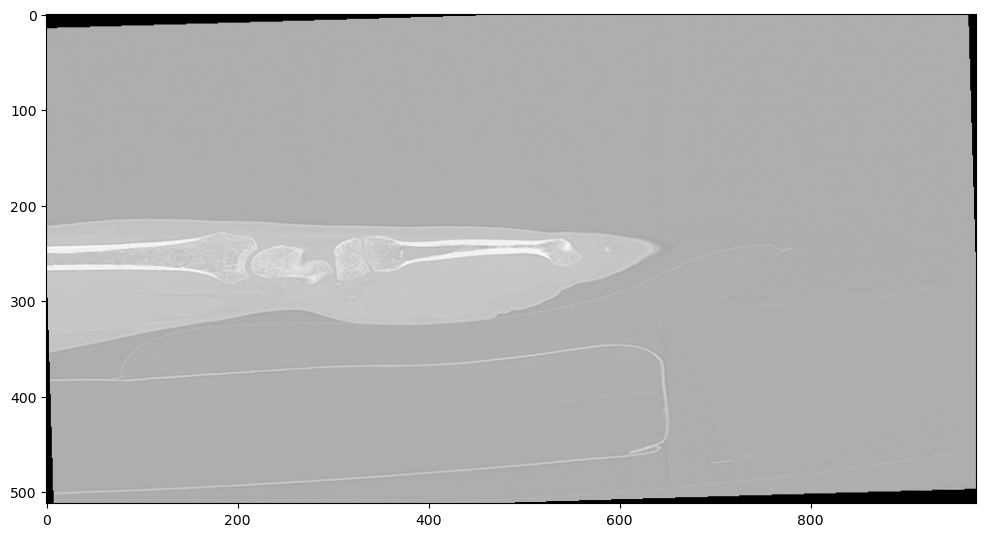

In [97]:
tifffile.imwrite('06_from_pictmono_xrr152.tiff', flipped_mono)
image = tifffile.imread('06_from_pictmono_xrr152.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h3 style="color:MidnightBlue;">1.9 Определение на вертикальном сечении проекции "projection_yrr" координату сечения горизонтальной плоскостью</h3>

In [98]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('06_from_pictmono_xrr152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (122, 254)


<h3 style="color:MidnightBlue;">1.10 Сечение массива второго поворота "twice_rotated_volume152" плоскостями на высоте 252,254,256</h3>

In [99]:
twice_rotated_volume152.shape

(512, 512, 974)

In [100]:
pictt1 = twice_rotated_volume152[252]
# Зеркальное отражение изображения слева направо
#flipped_pictt1 = np.flip(pictt1, axis=1)
flipped_pictt11 = np.transpose(pictt1, (1, 0))

In [101]:
pictt2 = twice_rotated_volume152[254]
# Зеркальное отражение изображения слева направо
#flipped_pictt2 = np.flip(pictt2, axis=1)
flipped_pictt22 = np.transpose(pictt2, (1, 0))

In [102]:
pictt3 = twice_rotated_volume152[256]
# Зеркальное отражение изображения слева направо
#flipped_pictt3 = np.flip(pictt3, axis=1)
flipped_pictt33 = np.transpose(pictt3, (1, 0))

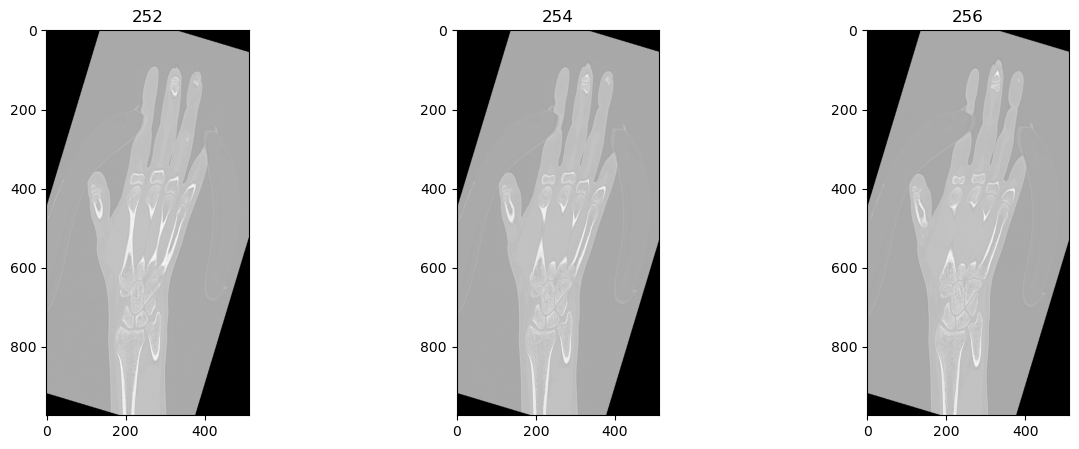

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(flipped_pictt11, cmap='gray')
axs[0].set_title('252')

axs[1].imshow(flipped_pictt22, cmap='gray')
axs[1].set_title('254')

axs[2].imshow(flipped_pictt33, cmap='gray')
axs[2].set_title('256')

plt.show()

<h4 style="color:Blue;">1.10.1 Обрезка изображений</h4>

In [104]:
tifffile.imwrite('15_252_152.tiff', flipped_pictt11) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_254_152.tiff', flipped_pictt22) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_256_152.tiff', flipped_pictt33) # Сохранение массива в TIFF-файл

#### 252

In [105]:
image = Image.open('15_252_152.tiff')

# размеры для обрезки
left = 150
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_252_152_bw.tiff')

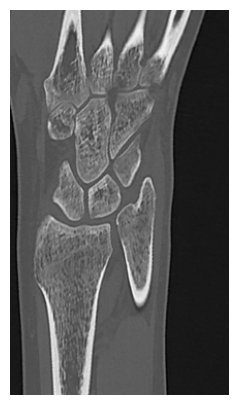

In [106]:
%matplotlib inline
gray_image282 = Image.open('16_252_152_bw.tiff')
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image282, cmap='gray')
plt.axis('off')
plt.show()

#### 254

In [107]:
image = Image.open('15_254_152.tiff')

# размеры для обрезки
left = 150
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_254_152_bw.tiff')

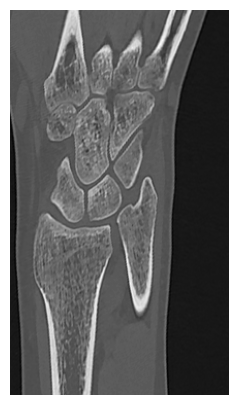

In [108]:
%matplotlib inline
gray_image152 = Image.open('16_254_152_bw.tiff')
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

#### 256

In [109]:
image = Image.open('15_256_152.tiff')

# размеры для обрезки
left = 150
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_256_152_bw.tiff')

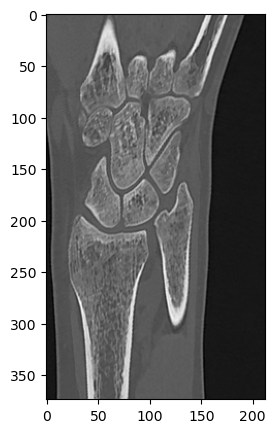

In [110]:
%matplotlib inline
gray_image152 = Image.open('16_256_152_bw.tiff')
plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [42]:
imagett = tifffile.imread('16_256_152_bw.tiff')
imagettt = np.array(imagett)
imagettt.shape

(374, 212)

In [112]:
print(imagett.min())
print(imagett.max())

6832
10783


<h3 style="color:MidnightBlue;">1.11 Сечение "16_256_152_bw.png" как предствитель класса HEALTHY</h3>

In [113]:
# Нормализуем изображение
image_norm = (imagett - imagett.min()) / (imagett.max() - imagett.min())
image_norm = (image_norm * 255).astype(np.uint8)

# Сохраняем нормализованное изображение в формате PNG
plt.imsave("16_256_152_bw.png", image_norm)

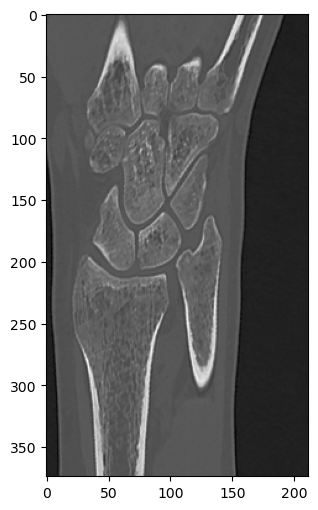

In [115]:
%matplotlib inline
gray_image152 = Image.open('16_256_152_bw.png')
gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(6, 6)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [41]:
imagexx = Image.open('16_256_152_bw.png')
imagexxx = np.array(imagexx)
imagexxx.shape

(374, 212, 4)

In [ ]:
imagett = tifffile.imread('16_256_152_bw.tiff')
# Нормализуем изображение
image_norm = (imagett - imagett.min()) / (imagett.max() - imagett.min())
image_norm = (image_norm * 255).astype(np.uint8)

# Сохраняем нормализованное изображение в формате PNG
plt.imsave("16_256_152_bw.png", image_norm)

<h1 style="color:red;">2. Числовые показатели HEALTHY сечения "16_256_152_bw.png"</h1>

<h3 style="color:Crimson;">2.1 Центры окружностей, проходящих через точки неподвижной и подвижной частей шарнира сустава</h3>

In [116]:
import cv2
import numpy as np
from sympy import Point, Circle

# Список для хранения координат точек
points = []

# Функция для нанесения точек на изображение
def draw_point(image, point, color, radius=3):
    cv2.circle(image, point, radius, color, -1)

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global points, image
    if event == cv2.EVENT_LBUTTONDOWN:
        # Добавить точку в список
        points.append((x, y))
        
        # Нанести синюю точку
        draw_point(image, (x, y), (255, 0, 0))
        cv2.imshow('Image', image)
        
        # Если было добавлено три точки, вычислить и нанести центр окружности
        if len(points) == 3:
            center = find_circle_center(points[0], points[1], points[2])
            draw_point(image, center, (0, 0, 255))
            cv2.imshow('Image', image)
            
            # Сохранение изображения с нанесёнными точками
            cv2.imwrite('result_16_256_152_bw.png', image)
            print('Изображение сохранено как result_image.jpg')

# Функция для вычисления центра окружности, проходящей через три точки
def find_circle_center(p1, p2, p3):
    c = Circle(Point(p1), Point(p2), Point(p3))
    center = c.center.evalf()
    return (int(center.x), int(center.y))

# Чтение изображения
image = cv2.imread('16_256_152_bw.png')
if image is None:
    raise ValueError('Не удалось загрузить изображение по пути')

# Создание окна и установка обработчика событий мыши
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', mouse_callback)

# Отображение изображения
cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Изображение сохранено как result_image.jpg


In [126]:
import cv2
import numpy as np
from sympy import Point, Circle

# Список для хранения координат точек
points = []

# Функция для нанесения точек на изображение
def draw_point(image, point, color, radius=3):
    cv2.circle(image, point, radius, color, -1)

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global points, image
    if event == cv2.EVENT_LBUTTONDOWN:
        # Добавить точку в список
        points.append((x, y))
        
        # Нанести синюю точку
        draw_point(image, (x, y), (255, 0, 0))
        cv2.imshow('Image', image)
        
        # Если было добавлено три точки, вычислить и нанести центр окружности
        if len(points) == 3:
            center = find_circle_center(points[0], points[1], points[2])
            draw_point(image, center, (0, 0, 255))
            cv2.imshow('Image', image)
            
            # Сохранение изображения с нанесёнными точками
            cv2.imwrite('2result_16_256_282_bw.png', image)
            print('Изображение сохранено как result_image.jpg')

# Функция для вычисления центра окружности, проходящей через три точки
def find_circle_center(p1, p2, p3):
    c = Circle(Point(p1), Point(p2), Point(p3))
    center = c.center.evalf()
    return (int(center.x), int(center.y))

# Чтение изображения
image = cv2.imread('result_16_256_152_bw.png')
if image is None:
    raise ValueError('Не удалось загрузить изображение по пути')

# Создание окна и установка обработчика событий мыши
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', mouse_callback)

# Отображение изображения
cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Изображение сохранено как result_image.jpg


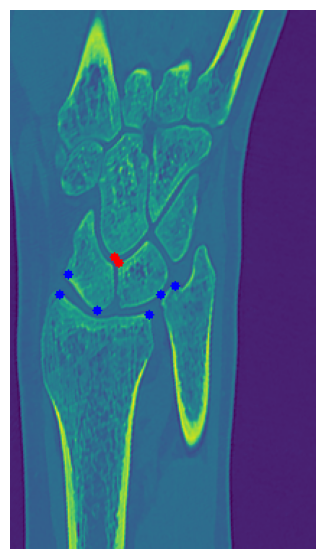

In [3]:
plt.figure(figsize=(7, 7))
%matplotlib inline
gray_image542 = Image.open('2result_16_256_282_bw.png')
plt.imshow(gray_image542, cmap='gray') #
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h3 style="color:Crimson;">2.2 Угол наклона сустава лучевой кости</h3>

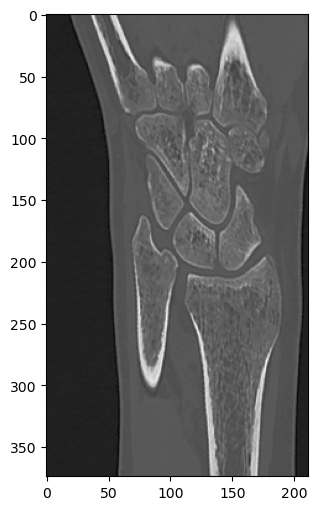

In [57]:
%matplotlib inline
gray_image152 = Image.open('16_256_152_bw.png')
gray_image152 = gray_image152.convert("L")
flipped_pictt152 = np.flip(gray_image152, axis=1)
# Сохранить изображение в формате PNG
cv2.imwrite('17_256_152_bw.png', flipped_pictt152)
image = Image.open('17_256_152_bw.png')
plt.figure(figsize=(6, 6)) # Отображение изображения в оттенках серого
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

In [5]:
import cv2
import numpy as np

# Чтение изображения
image = cv2.imread('17_256_152_bw.png')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: image1_contrast.png')

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
drawing = False

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = -angle

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} degr', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('17_256_152_bw_the radius_angle.png', overlay)

cv2.destroyAllWindows()

Угол между линией №1 и горизонтом: 17.61 градусов
Горизонтальная линия нарисована через точку: (4, 247)


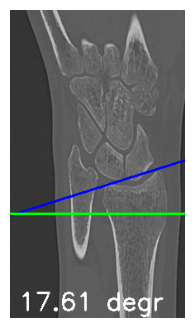

In [4]:
plt.figure(figsize=(4, 4))
%matplotlib inline
gray_image542 = Image.open('17_256_152_bw_the radius_angle.png')
plt.imshow(gray_image542, cmap='gray') #
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h3 style="color:Crimson;">2.3 Перепад высот костей в шарнире сустава</h3>

In [6]:
image_path = '16_256_152_bw.png'
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: {image_path}')

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, overlay
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append(y)  # Сохраняем только координату y для горизонтальных линий

        if len(clicks) == 1:
            cv2.line(overlay, (0, y), (image.shape[1], y), (255, 0, 0), 2)
        elif len(clicks) == 2:
            cv2.line(overlay, (0, y), (image.shape[1], y), (0, 255, 0), 2)

            # Расчет расстояния между линиями по вертикали
            a = abs(clicks[1] - clicks[0])
            print(f'Расстояние между линиями: {a} пикселей')

            # Вывод расстояния на изображение внизу
            text_position = (10, image.shape[0] - 10)
            cv2.putText(overlay, f'{a} pixels', text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Показать обновленное изображение
            cv2.imshow('Изображение', overlay)

            # Сохранение измененного изображения
            cv2.imwrite('18_256_152_bw_radius_distance.png', overlay)

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Расстояние между линиями: 14 пикселей


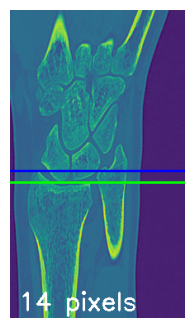

In [7]:
plt.figure(figsize=(4, 4))
%matplotlib inline
gray_image542 = Image.open('18_256_152_bw_radius_distance.png')
plt.imshow(gray_image542, cmap='gray') #
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h3 style="color:Crimson;">2.4 Суставная щель у полулунной кости</h3>

In [8]:
matplotlib.use('TkAgg')  
image_path = '16_256_152_bw.png'
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: {image_path}')

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, overlay
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append(y)  # Сохраняем только координату y для горизонтальных линий

        if len(clicks) == 1:
            cv2.line(overlay, (0, y), (image.shape[1], y), (255, 0, 0), 2)
        elif len(clicks) == 2:
            cv2.line(overlay, (0, y), (image.shape[1], y), (0, 255, 0), 2)

            # Расчет расстояния между линиями по вертикали
            a = abs(clicks[1] - clicks[0])
            print(f'Расстояние между линиями: {a} пикселей')

            # Вывод расстояния на изображение внизу
            text_position = (10, image.shape[0] - 10)
            cv2.putText(overlay, f'{a} pixels', text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Показать обновленное изображение
            cv2.imshow('Изображение', overlay)

            # Сохранение измененного изображения
            cv2.imwrite('19_256_152_bw_radius_semilunar_distance.png', overlay)

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Расстояние между линиями: 5 пикселей


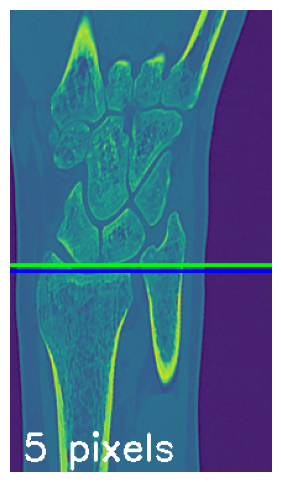

In [9]:
plt.figure(figsize=(6, 6))
%matplotlib inline
gray_image542 = Image.open('19_256_152_bw_radius_semilunar_distance.png')
plt.imshow(gray_image542, cmap='gray') #
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h3 style="color:Crimson;">2.5 Произвольное расстояние переведённое в милиметры (соотношение принято 0,5)</h3>

In [13]:
matplotlib.use('TkAgg')  
image_path = "16_256_152_bw.png" 
image = plt.imread(image_path)

# Отображение изображения на экране во всплывающем окне
fig, ax = plt.subplots()
ax.imshow(image)

# 2) Пометка двух точек на изображении
points = []

def onclick(event):
    if len(points) < 2:
        x, y = event.xdata, event.ydata
        ax.plot(x, y, 'ro')  # Пометка точки красным 
        points.append((x, y))
        if len(points) == 2:
            # 3) Определение расстояния между помеченными точками в миллиметрах
            pixel_distance = 0.5  # Расстояние в миллиметрах для одного пикселя
            x_distance = abs(points[1][0] - points[0][0]) * pixel_distance
            y_distance = abs(points[1][1] - points[0][1]) * pixel_distance
            distance = np.sqrt(x_distance**2 + y_distance**2)
            
            # 4) Нанесение значения расстояния по координатам 60,40
            ax.text(25,25, f"Distance: {distance:.2f} mm", color='white', fontsize=12)
            plt.draw()

cid = fig.canvas.mpl_connect("button_press_event", onclick)

# Ожидание двух кликов мыши
plt.waitforbuttonpress()
plt.waitforbuttonpress()

# 5) Сохранение изображения без прозрачности
output_path = "20_256_152_bw_just_the_distance.png"  # Замените на путь для сохранения изображения
plt.savefig(output_path, transparent=False)

# 6) Закрытие изображения
plt.close()

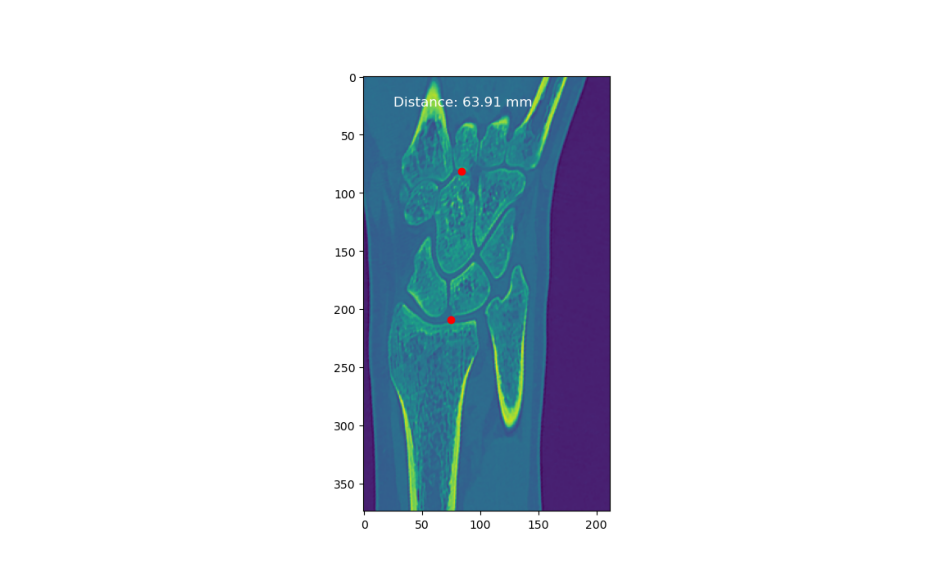

In [15]:
plt.figure(figsize=(12, 12))
%matplotlib inline
gray_image542 = Image.open('20_256_152_bw_just_the_distance.png')
plt.imshow(gray_image542, cmap='gray') #
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h1 style="color:Crimson;">3. Отрисовка замкнутой объёмной арки Gilula с определением средней ширины арки</h1>

<h3 style="color:Crimson;">3.1 Дополнительная обрезка 4-х канального изображения под линию</h3>

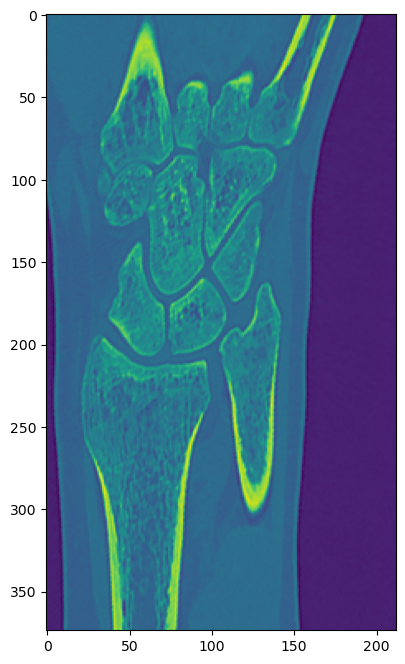

In [106]:
plt.figure(figsize=(8, 8))
%matplotlib inline
gray_image542 = Image.open('16_256_152_bw.png')
plt.imshow(gray_image542, cmap='gray') #
#plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

In [107]:
image3 = Image.open('17_256_152_bw.png')
imageqq = np.array(image3)
imageqq.shape

(374, 212)

In [108]:
image = Image.open('16_256_152_bw.png')

# размеры для обрезки
left = 15
top = 100
right = 50
bottom = 125

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_256_152_gilula.png')

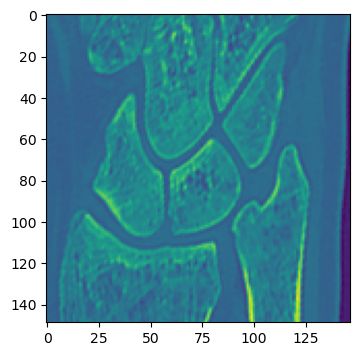

In [109]:
plt.figure(figsize=(4, 4))
%matplotlib inline
gray_image542 = Image.open('16_256_152_gilula.png')
plt.imshow(gray_image542, cmap='gray') #
#plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h3 style="color:Crimson;">3.2 Замкнутая линия и df</h3>

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

df = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '16_256_152_gilula.png'  # Путь к изображению
image = Image.open(image_path).convert("RGBA")

# изображение в массив numpy для отображения через matplotlib
image_array = np.array(image)

# список для хранения точек
points = []

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=2)
        fig.canvas.draw()
        
        # Когда было выбрано 51 точек или больше, нарисовать кривую линию
        if len(points) == 51:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_line_image(line_image)  # Добавляем этот вызов
            save_internal_pixels_list(points)  # Сначала сохраним изображение, затем пиксели
            fig.canvas.mpl_disconnect(cid)
            
# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.2)  # Рисование линии
    fig.canvas.draw()
    
     # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("16_256_152_gilula_and_1_line.png")
    print("Изображение сохранено как 16_256_152_gilula_and_1_line.png")
    
# Функция для сохранения только линии в отдельный файл
def save_line_image(line_image):
    line_image.save("first_line_only.png")
    print("Изображение линии сохранено как first_line_only.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points):
    mask = Image.new("L", image.size, 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    df.loc[len(df)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(df)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Изображение сохранено как 16_256_152_gilula_and_1_line.png
Изображение линии сохранено как first_line_only.png
Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [[31, 150, 139, 255], [36, 132, 141, 255], [50...


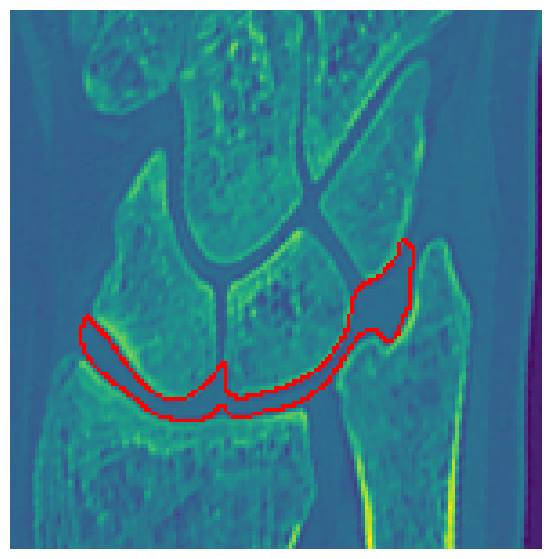

In [111]:
%matplotlib inline
gray_image152 = mpimg.imread('16_256_152_gilula_and_1_line.png')
plt.figure(figsize=(7, 7)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

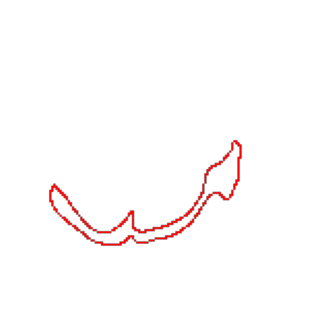

In [112]:
%matplotlib inline
gray_image152 = mpimg.imread('first_line_only.png')
plt.figure(figsize=(4, 4)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

In [113]:
df

pixels_inside_curve
0  [[31, 150, 139, 255], [36, 132, 141, 255], [50...

<h3 style="color:Crimson;">3.3 Количество пикселей на площади замкнутой кривой</h3>

In [114]:
len(df.iloc[0,0])

889

<h3 style="color:Crimson;">3.4 Центральная линия суставной щели</h3>

In [116]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
from PIL import Image, ImageDraw
import numpy as np
from scipy.interpolate import splprep, splev

# Устанавливаем backend TkAgg для matplotlib
matplotlib.use('TkAgg')

# Путь к изображению
image_path = '16_256_152_gilula_and_1_line.png'
image = Image.open(image_path).convert("RGBA")

# Конвертируем изображение в массив numpy для отображения через matplotlib
image_array = np.array(image)

# Создаем список для хранения точек и глобальную переменную для хранения пикселей линии
points = []
line_pixels = []  # Глобальная переменная для хранения пикселей линии

# Обработчик кликов
def onclick(event):
    global points, line_pixels
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=2)
        fig.canvas.draw()
        
        # Когда было выбрано 41 точек, нарисовать кривую линию
        if len(points) == 41:
            line_image, line_pixels = draw_spline(points)
            save_combined_image(line_image)
            save_line_image(line_image)
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    
    # Рассчитываем длину кривой и генерируем переменное количество точек
    lengths = np.hypot(np.diff(x), np.diff(y))
    total_length = np.sum(lengths)
    num_points = int(total_length)
    
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = splev(u_new, tck, ext=0)

    # Собираем пиксели линии в глобальную переменную line_pixels
    global line_pixels
    line_pixels = list(zip(x_new.astype(int), y_new.astype(int)))  # Преобразуем координаты к целым числам
    #print(f'Список пикселей линии: {line_pixels}')
    
    ax.plot(x_new, y_new, 'r-', lw=1.0)  # Рисование непрозрачной линии
    fig.canvas.draw()
    
    # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    
    return line_image, line_pixels

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("16_256_152_gilula_and_2_line.png")
    print("Изображение сохранено как 16_256_152_gilula_and_2_line.png")

# Функция для сохранения только линии в отдельный файл
def save_line_image(line_image):
    line_image.save("second_line_only.png")
    print("Изображение линии сохранено как sec_line_only.png")

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# Пример дальнейшего использования line_pixels
print(f'Глобальный список пикселей линии для дальнейшего использования: {line_pixels}')

Глобальный список пикселей линии для дальнейшего использования: []
Изображение сохранено как 16_256_152_gilula_and_2_line.png
Изображение линии сохранено как sec_line_only.png


In [117]:
len(line_pixels[::])

124

In [118]:
line_pixels[1]

(19, 87)

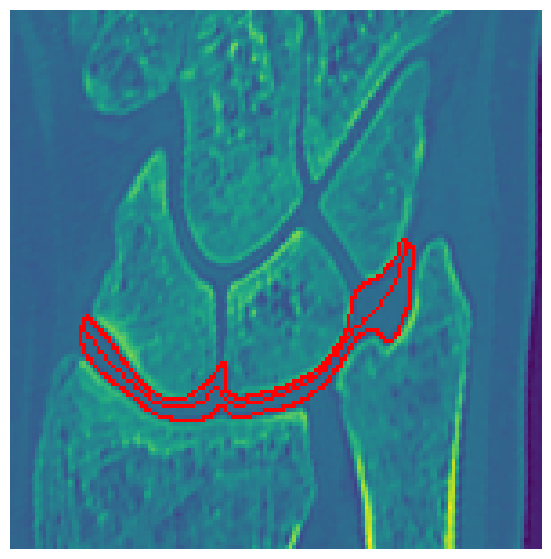

In [119]:
%matplotlib inline
gray_image152 = mpimg.imread('16_256_152_gilula_and_2_line.png')
plt.figure(figsize=(7, 7)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

<h3 style="color:Crimson;">3.4 Среднее значение ширины суставной щели в пикселях</h3>

In [123]:
h = len(df.iloc[0,0])/len(line_pixels[::])
h

7.169354838709677

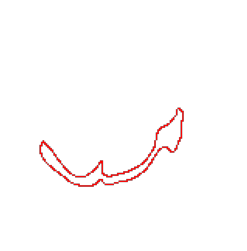

In [124]:
%matplotlib inline
gray_image152 = mpimg.imread('first_line_only.png')
plt.figure(figsize=(3, 3)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

<h1 style="color:Blue;">4. Распределения значений пикселей по каналам RGB</h1>

<h2 style="color:Blue;">Healthy горизонтальное сечение</h2>

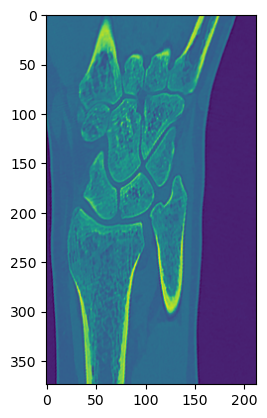

In [125]:
%matplotlib inline
image152 = Image.open('16_256_152_bw.png')
plt.imshow(image152, cmap='gray')
#plt.axis('off')
plt.show()

<h3 style="color:blue;">4.1 На лучевой кости снятие значений пикселей с площади внутри замкнутой кривой линии</h3>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

df15 = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '16_256_152_bw.png'  # Путь к изображению
image = Image.open(image_path).convert("RGBA")

# Конвертируем изображение в массив numpy для отображения через matplotlib
image_array = np.array(image)

# Создаем список для хранения точек
points = []

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=3)
        fig.canvas.draw()
        
        # Когда было выбрано 41 точек или больше, нарисовать кривую линию
        if len(points) == 41:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_internal_pixels_list(points)  # Сначала сохраним изображение, затем пиксели
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.0)  # Рисование линии
    fig.canvas.draw()
    
     # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("16_256_152_and_line.png")
    print("Изображение сохранено как 16_256_152_and_line.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points):
    mask = Image.new("L", image.size, 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    df15.loc[len(df15)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(df15)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Изображение сохранено как 16_256_152_and_line.png
Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [[35, 135, 141, 255], [41, 121, 142, 255], [38...


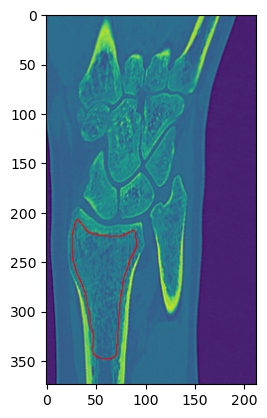

In [4]:
%matplotlib inline
image152 = Image.open('16_256_152_and_line.png')
plt.imshow(image152, cmap='gray')
#plt.axis('off')
plt.show()

In [5]:
df15

pixels_inside_curve
0  [[35, 135, 141, 255], [41, 121, 142, 255], [38...

<h3 style="color:blue;">4.2 Количество и значения пикселей на ограниченном линией участке</h3>

In [ ]:
# Каличество пикселей
len(df15.iloc[0,0])

In [7]:
# значения пикселя по каналам
c15 = df15.iloc[0,0]
c15[0]

[35, 135, 141, 255]

In [8]:
# КРАСНЫЙ СПИСОК
listic15R = [sublist[0] for sublist in c15]  # Список первых элементов
print(listic15R[0:10])
print(min(listic15R))
print(max(listic15R))

[35, 41, 38, 32, 39, 42, 37, 38, 41, 46]
30
69


In [9]:
# ЗЕЛЁНЫЙ СПИСОК
listic15G = [sublist[1] for sublist in c15]  # Список первых элементов
print(listic15G[0:10])
print(min(listic15G))
print(max(listic15G))

[135, 121, 129, 145, 124, 117, 130, 128, 121, 109]
72
191


In [10]:
# СИНИЙ СПИСОК
listic15B = [sublist[2] for sublist in c15]  # Список первых элементов
print(listic15B[0:10])
print(min(listic15B))
print(max(listic15B))

[141, 142, 142, 140, 142, 142, 142, 142, 142, 142]
111
142


In [13]:
import pickle
with open('listic15R.pkl', 'wb') as f:
    pickle.dump(listic15R, f)
with open('listic15G.pkl', 'wb') as f:
    pickle.dump(listic15G, f)
with open('listic15B.pkl', 'wb') as f:
    pickle.dump(listic15B, f)


In [18]:
import pickle
# Загрузка из pickle-файла
with open('listic15R.pkl', 'rb') as f:
    listic15R = pickle.load(f)
# Загрузка из pickle-файла
with open('listic15G.pkl', 'rb') as f:
    listic15G = pickle.load(f)
# Загрузка из pickle-файла
with open('listic15B.pkl', 'rb') as f:
    listic15B = pickle.load(f)


<h2 style="color:Blue;">12. Представление распределения вырезанной части изображения unhealthy</h2>

<h4 style="color:Blue;">12.1 Представление распределения вырезанной части изображения суммарно listic15R + listic15G</h4>

In [19]:
listic15RG = listic15R + listic15G 

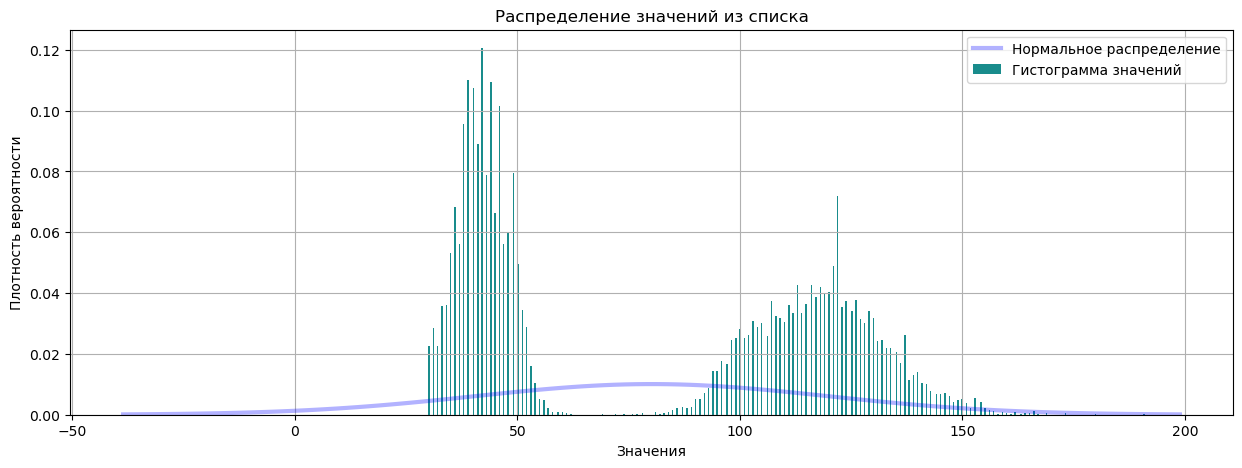

Эксцесс  -1.6718721872402496
Асимметрия  0.16770474239714592
Среднее значение пикселей: 80.1313285116102
Минимальное значение пикселей: 30
Минимальное значение пикселей: 191
Три наиболее часто встречающихся значения:
Значение: 42, Частота: 408
Значение: 39, Частота: 372
Значение: 44, Частота: 370


In [20]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic15RG) ######################################################################
std_dev = np.std(listic15RG) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic15RG, density=True, bins=500, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic15RG))######################################################
print("Асимметрия ", skew(listic15RG))####################################################

average = statistics.mean(listic15RG) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic15RG)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic15RG)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic15RG)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">12.2 Представление распределения вырезанной части изображения listic15R</h4>

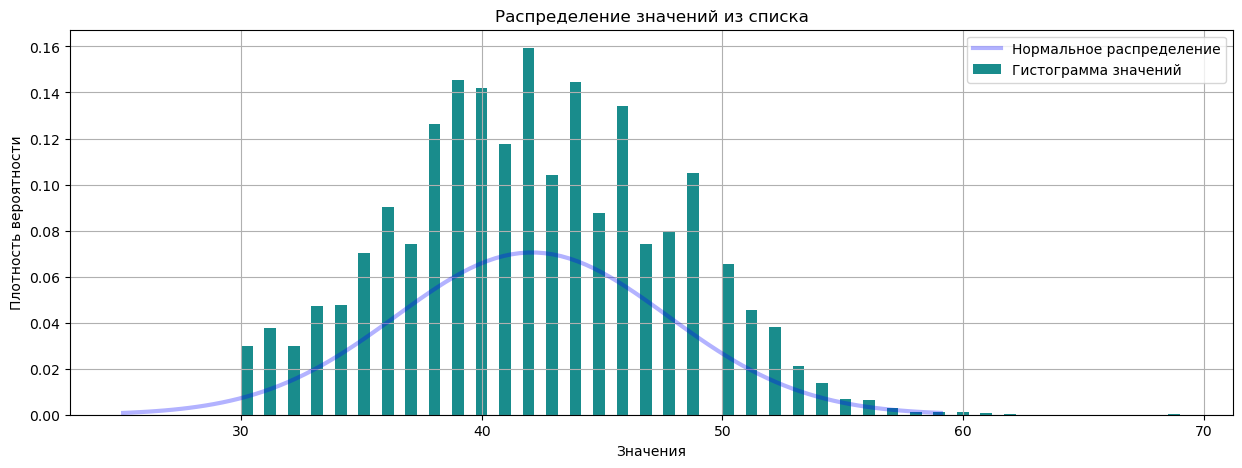

Эксцесс  -0.35071328165996496
Асимметрия  0.09034899334034102
Среднее значение пикселей: 42.08660068519224
Минимальное значение пикселей: 30
Минимальное значение пикселей: 69
Три наиболее часто встречающихся значения:
Значение: 42, Частота: 408
Значение: 39, Частота: 372
Значение: 44, Частота: 370


In [21]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic15R) ######################################################################
std_dev = np.std(listic15R) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic15R, density=True, bins=80, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic15R))######################################################
print("Асимметрия ", skew(listic15R))####################################################

average = statistics.mean(listic15R) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic15R)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic15R)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic15R)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (unhealthy)</h4>

Отношение объема пересечения к объему объединения: 0.7080407104425611


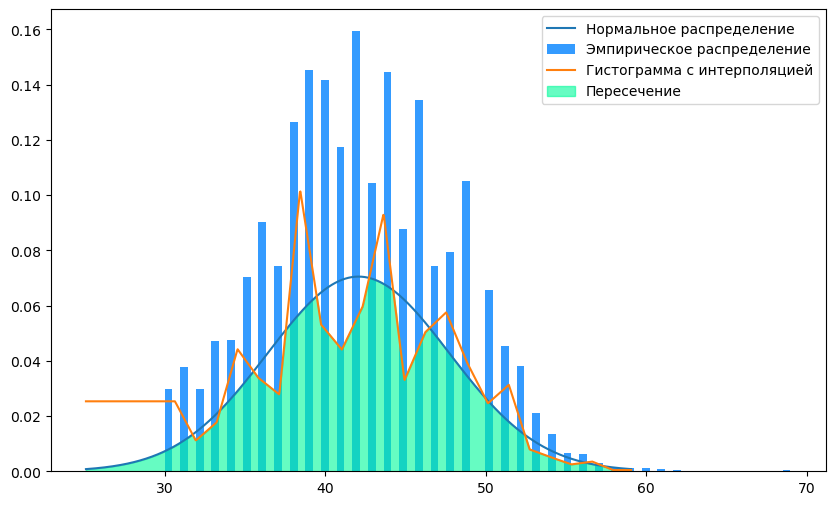

In [22]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic15R)
std_dev = np.std(listic15R)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic15R, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic15R, bins=80, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h2 style="color:Blue;">Пересечение гистограммы С НОРМОЙ</h2>

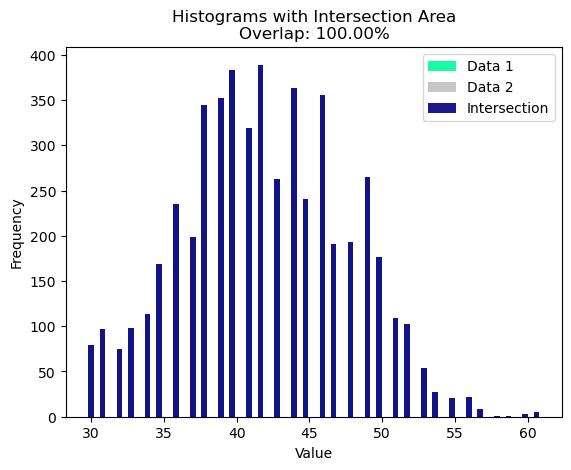

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic15R
data2 = listic15R

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 80

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='Silver', alpha=0.9, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.9, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

<h4 style="color:Blue;">4.3.3 Представление распределения вырезанной части изображения listic15G</h4>

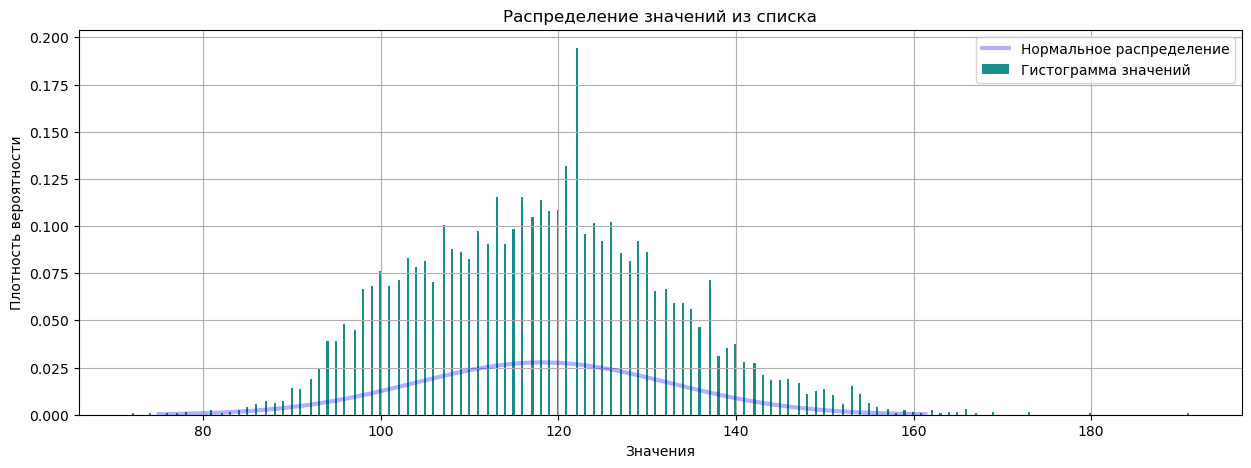

Эксцесс  0.08079361946388719
Асимметрия  0.27157734615991835
Среднее значение пикселей: 118.17605633802818
Минимальное значение пикселей: 72
Минимальное значение пикселей: 191
Три наиболее часто встречающихся значения:
Значение: 122, Частота: 243
Значение: 121, Частота: 165
Значение: 116, Частота: 144


In [8]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic15G) ######################################################################
std_dev = np.std(listic15G) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic15G, density=True, bins=500, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic15G))######################################################
print("Асимметрия ", skew(listic15G))####################################################

average = statistics.mean(listic15G) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic15G)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic15G)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic15G)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (healthy)</h4>

Отношение объема пересечения к объему объединения: 0.9022613255261581


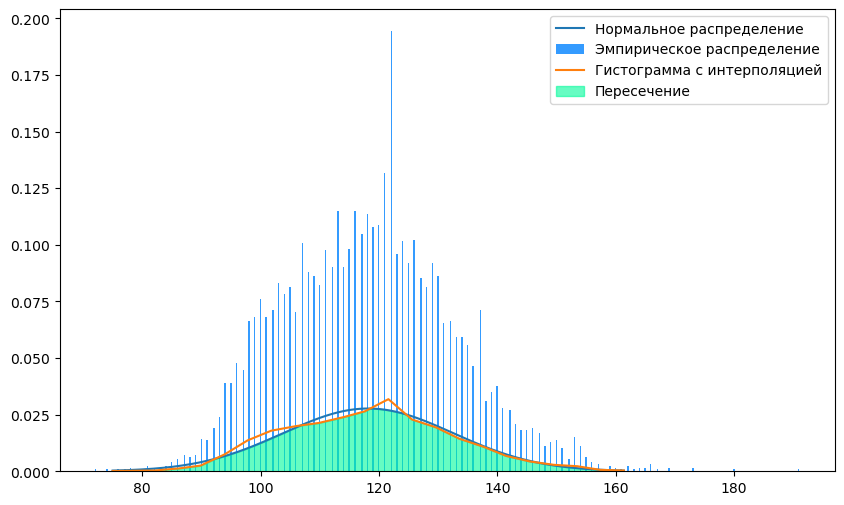

In [24]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic15G)
std_dev = np.std(listic15G)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic15G, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic15G, bins=500, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h4 style="color:Blue;">Пересечение гистограммы "сама с собой"</h4>

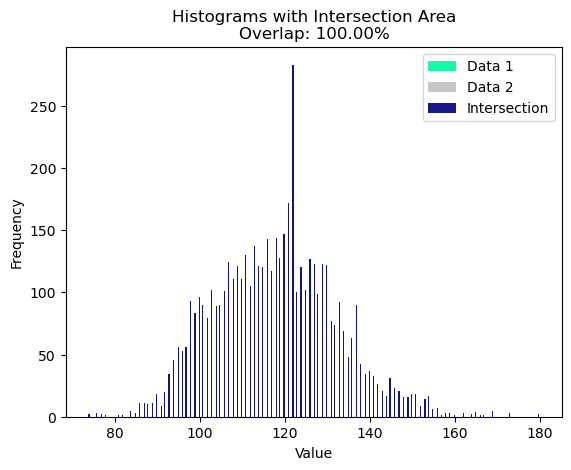

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic15G
data2 = listic15G

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 400

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='Silver', alpha=0.9, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.9, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

<h4 style="color:Blue;">4.3.2 Представление распределения вырезанной части изображения listic15B</h4>

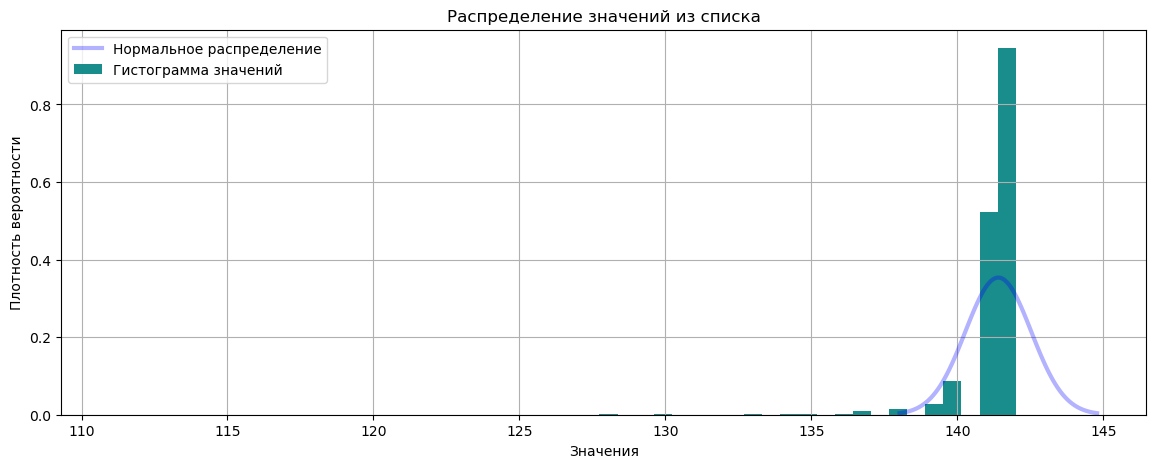

Эксцесс  136.74291740172876
Асимметрия  -7.728596987569422
Среднее значение пикселей: 42.08660068519224
Минимальное значение пикселей: 111
Минимальное значение пикселей: 142
Три наиболее часто встречающихся значения:
Значение: 142, Частота: 3080
Значение: 141, Частота: 1703
Значение: 140, Частота: 280


In [9]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic15B) ######################################################################
std_dev = np.std(listic15B) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(14, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic15B, density=True, bins=50, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic15B))######################################################
print("Асимметрия ", skew(listic15B))####################################################

average = statistics.mean(listic15R) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic15B)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic15B)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic15B)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (healthy)</h4>

Отношение объема пересечения к объему объединения: 0.22603219484342935


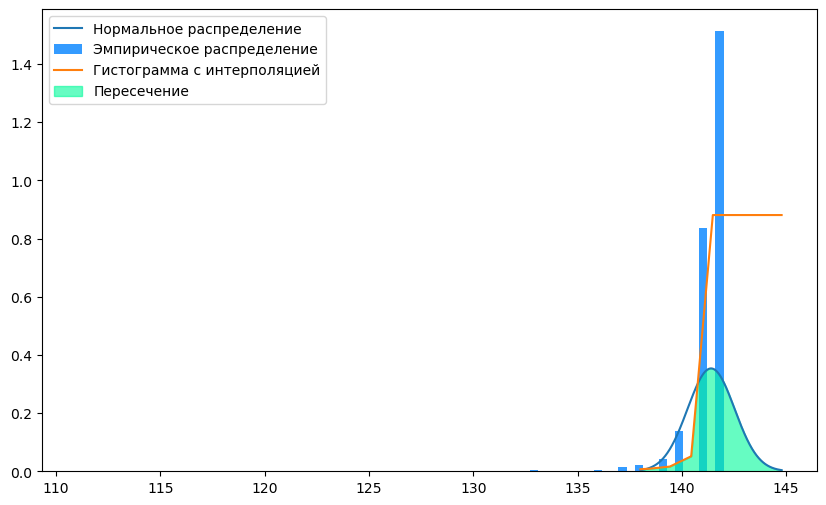

In [30]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic15B)
std_dev = np.std(listic15B)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic15B, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic15B, bins=80, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h4 style="color:Blue;">Пересечение гистограммы "сама с собой"</h4>

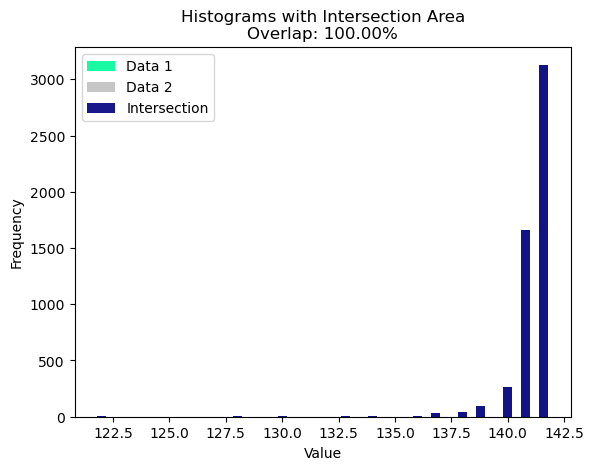

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic15B
data2 = listic15B

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 50

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='Silver', alpha=0.9, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.9, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

<h1 style="color:red;">PP_700/44(2) - патология</h1>

<h2 style="color:Navy;">1. Создание трехмерноо массива с проверками и преобразованиями при необходимости</h2>

In [10]:
directory = 'D:/AleksandrovTI//PP_700/44(2)'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume442 = np.stack([s[0] for s in slices], axis=-1)
print(volume442.shape)

(512, 512, 949)


<h2 style="color:Navy;">2. Визуализация по стандартным проекцим</h2>

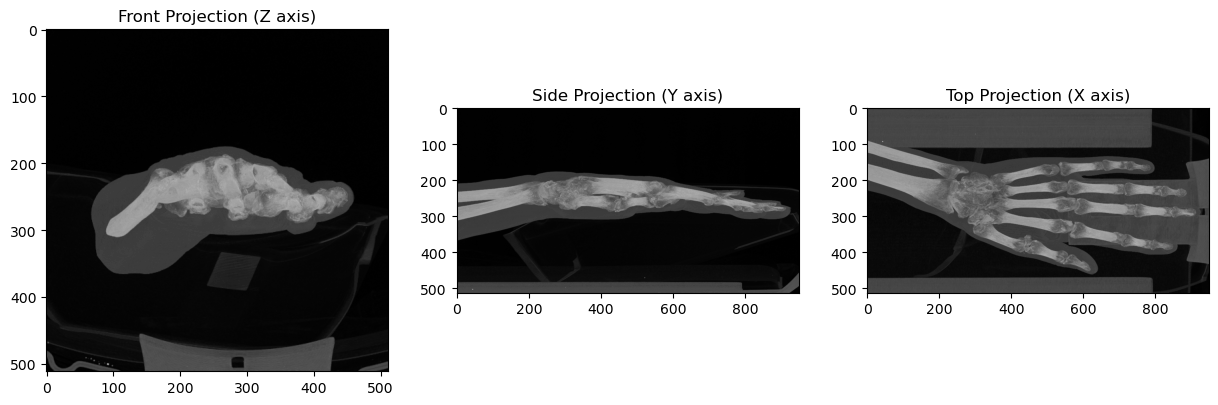

In [11]:
projection_z442 = np.max(volume442, axis=2) # Front projection (по оси Z)
projection_y442 = np.max(volume442, axis=1) # Side projection (по оси Y)
projection_x442 = np.max(volume442, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z442, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y442, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x442, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">3. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ  X</h2>

<h4 style="color:Navy;">3.1 Сохранение массива в TIFF-файл Top projection (по оси X)</h4>

In [12]:
# Top projection (по оси X)
projection_x442 = np.max(volume442, axis=0)
tifffile.imwrite('01_projection_x442.tiff', projection_x442) # Сохранение массива в TIFF-файл

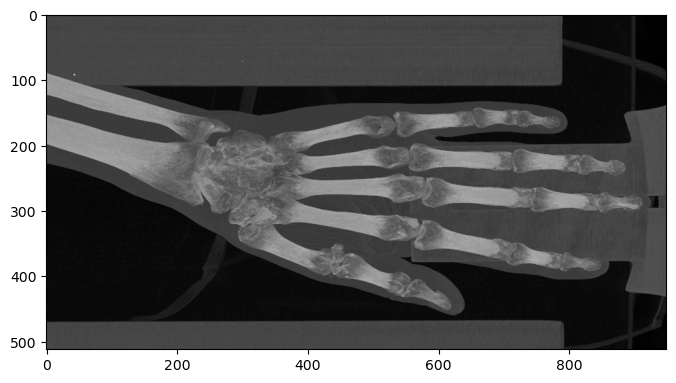

In [13]:
# Отображение изображения
image = tifffile.imread('01_projection_x442.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">3.2 Построение угла</h4>

In [18]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('01_projection_x442.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} degr', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('02_projection_x442_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: -15.73 градусов
Горизонтальная линия нарисована через точку: (5, 176)
Углы, сохраненные в программе: [-15.732004785107305]


In [19]:
print(angle)

-15.732004785107305


In [20]:
c1 = angle
c1

-15.732004785107305

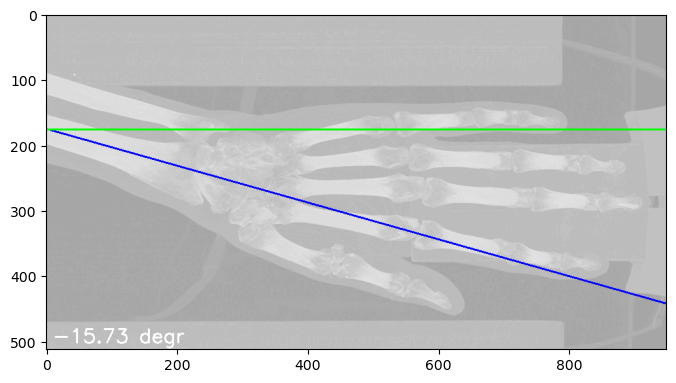

In [21]:
# Отображение изображения
image1 = tifffile.imread('02_projection_x442_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">4. Поворот плоскостей вокруг оси Z с заданным углом поворота - получение  'rotated_volume442'</h2>

Original volume shape: (512, 512, 949)
Rotated volume shape: (512, 512, 949)


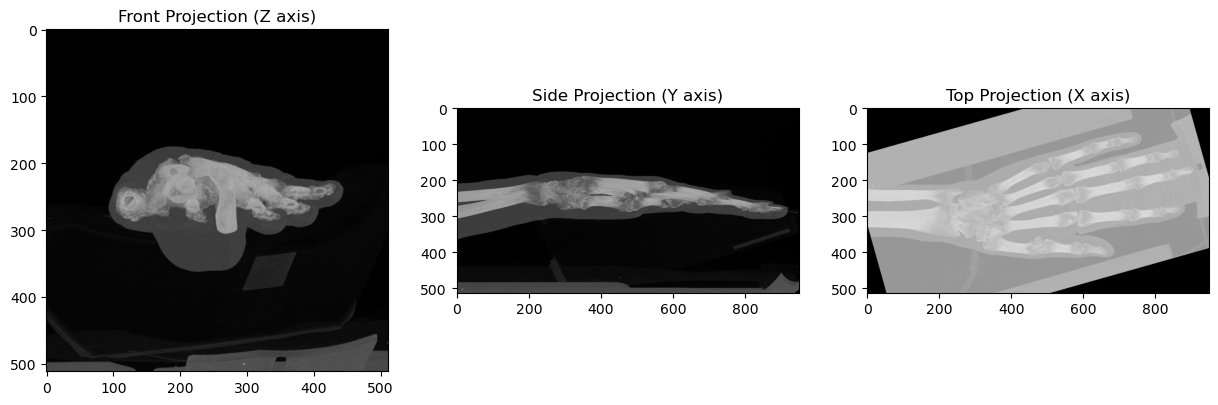

In [22]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'D:/AleksandrovTI//PP_700/44(2)'

# Чтение и нормализация изображения
volume442 = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume442.shape)

# Угол поворота 
angle = c1

# Поворот объёма вокруг оси Z
rotated_volume442 = rotate_volume(volume442, angle)
print("Rotated volume shape:", rotated_volume442.shape)

# Получение проекций после поворота
projection_xr, projection_yr, projection_zr = get_projections(rotated_volume442)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">5. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ Y</h2>

<h4 style="color:Navy;">5.1 Сохранение массива в TIFF-файл Side Projection (Y axis)</h4>

In [23]:
# Side Projection (Y axis)
projection_yr442 = np.max(rotated_volume442, axis=1)
projection_yr442 = np.flip(projection_yr442, axis=1) # ИСПРАВЛЕНИЕ ВЫВОДА ЗЕРКАЛЬНОГО ИЗОБРАЖЕНИЯ
tifffile.imwrite('03_projection_yr442.tiff', projection_yr442)

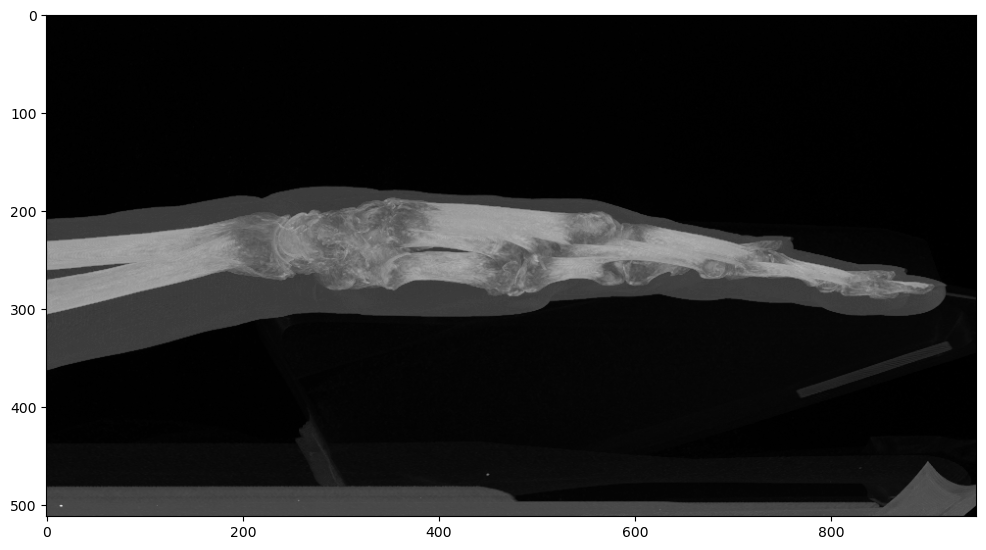

In [24]:
# Отображение изображения
image = tifffile.imread('03_projection_yr442.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">5.2 Построение угла</h4>

In [26]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('03_projection_yr442.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} degr', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('04_projection_yr442_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: 3.32 градусов
Горизонтальная линия нарисована через точку: (13, 247)
Углы, сохраненные в программе: [3.3214757633460423]


In [27]:
angle

3.3214757633460423

In [28]:
d1 = angle
d1

3.3214757633460423

In [29]:
c1

-15.732004785107305

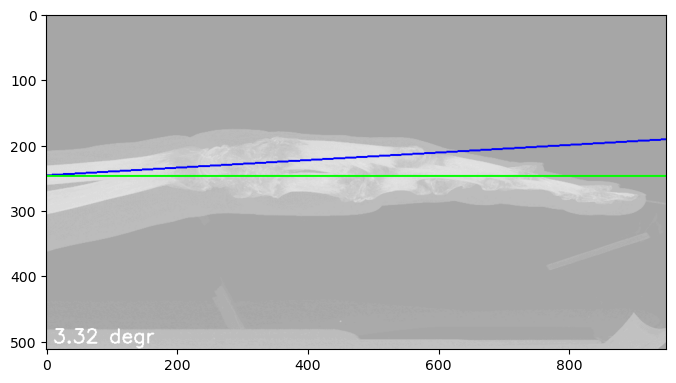

In [30]:
# Отображение изображения
image1 = tifffile.imread('04_projection_yr442_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">6. Поворот плоскостей вокруг оси Y с заданным углом поворота - получение  'twice_rotated_volume442'</h2>

Rotated volume shape: (512, 512, 949)


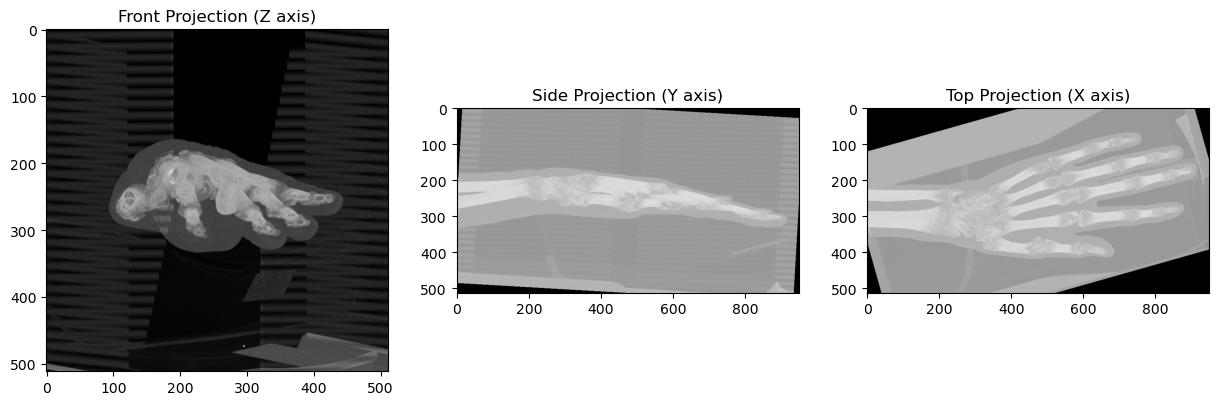

In [31]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xxx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yyy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zzz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xxx, projection_yyy, projection_zzz

# Угол поворота 
angle = d1

# Поворот объёма вокруг оси Y
twice_rotated_volume442 = rotate_volume(rotated_volume442, angle)
print("Rotated volume shape:", twice_rotated_volume442.shape)

# Получение проекций после ВТОРОГО поворота
projection_xrr, projection_yrr, projection_zrr = get_projections(twice_rotated_volume442)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zrr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yrr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xrr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">7. Определение сечений</h2>

<h4 style="color:Navy;">7.1 Вывод проекции Х в twice_rotated_volume152 для определения координаты СРЕДИННОГО сечения искомого массива</h4>

In [32]:
# Top projection (по оси X)
projection_xrr442 = np.max(twice_rotated_volume442, axis=0)
projection_xrr442 = np.flip(projection_xrr442, axis=1)
tifffile.imwrite('05_projection_xrr442.tiff', projection_xrr442)

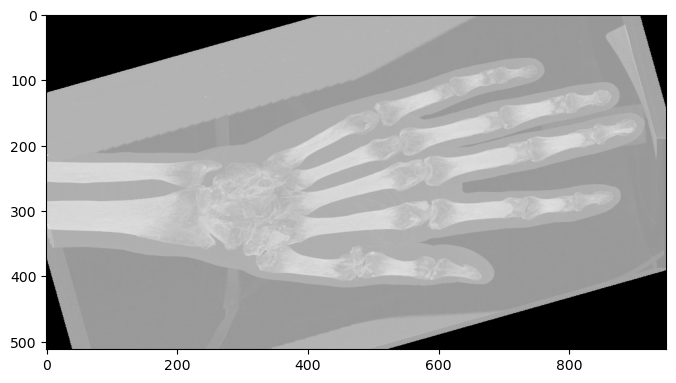

In [33]:
# Отображение изображения
image = tifffile.imread('05_projection_xrr442.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.2 Определениt координаты СРЕДИННОГО сечения искомого массива</h4>

In [34]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('05_projection_xrr442.tiff')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (98, 308)


<h4 style="color:Navy;">7.3 Изображение с ценой деления 10 для уточнения размера интервала третьего измерения искомого массива</h4>

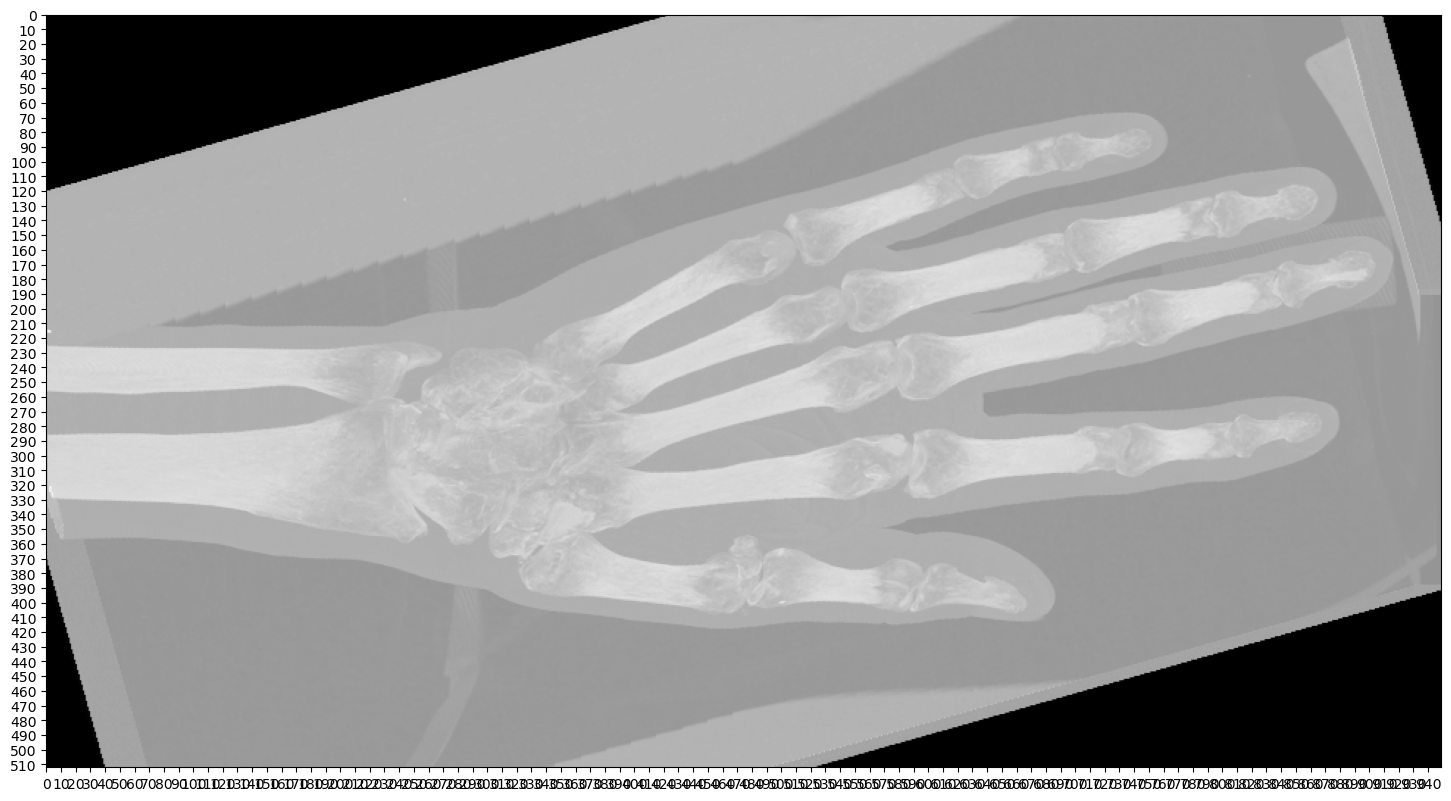

In [35]:
gray_image = mpimg.imread('05_projection_xrr442.tiff')

# Создание фигуры и осей
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(18, 12))  # Увеличенный размер холста
# Отображение изображения
ax.imshow(gray_image, cmap='gray', extent=[0, gray_image.shape[1], gray_image.shape[0], 0])

# Настройка тиков по осям x и y с шагом 20
ax.set_xticks(np.arange(0, gray_image.shape[1], 10))
ax.set_yticks(np.arange(0, gray_image.shape[0], 10))

# Показ графика
plt.show()

<h4 style="color:Navy;">7.4 Транспонирование twice_rotated_volume542 в нужную форму для получения искомых массива сечений</h4>

In [36]:
vol = np.transpose(twice_rotated_volume442, (1, 2, 0))
vol.shape

(512, 949, 512)

<h4 style="color:Navy;">7.5 Выбранный размер ОБЪЁМНОГО массива сечений кости</h4>

In [37]:
pict = vol[308]
pict.shape

(949, 512)

In [38]:
pict = np.transpose(pict, (1, 0))
flipped_mono = np.flip(pict, axis=1)
print(f"Исходный массив: {pict.shape}")
print(f"Преобразованный массив: {flipped_mono.shape}")

Исходный массив: (512, 949)
Преобразованный массив: (512, 949)


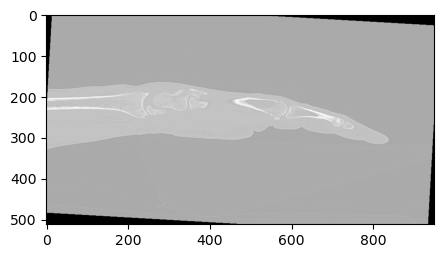

In [39]:
# Сохранение массива в TIFF-файл
tifffile.imwrite('06_projection_xrr442.tiff', flipped_mono)
# Отображение изображения
image = tifffile.imread('06_projection_xrr442.tiff')
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">9. Раскрытие суставных щелей</h2>

<h4 style="color:Navy;">9.1 Ветикальное сечение проекции "projection_yrr" Side Projection (Y axis)</h4>

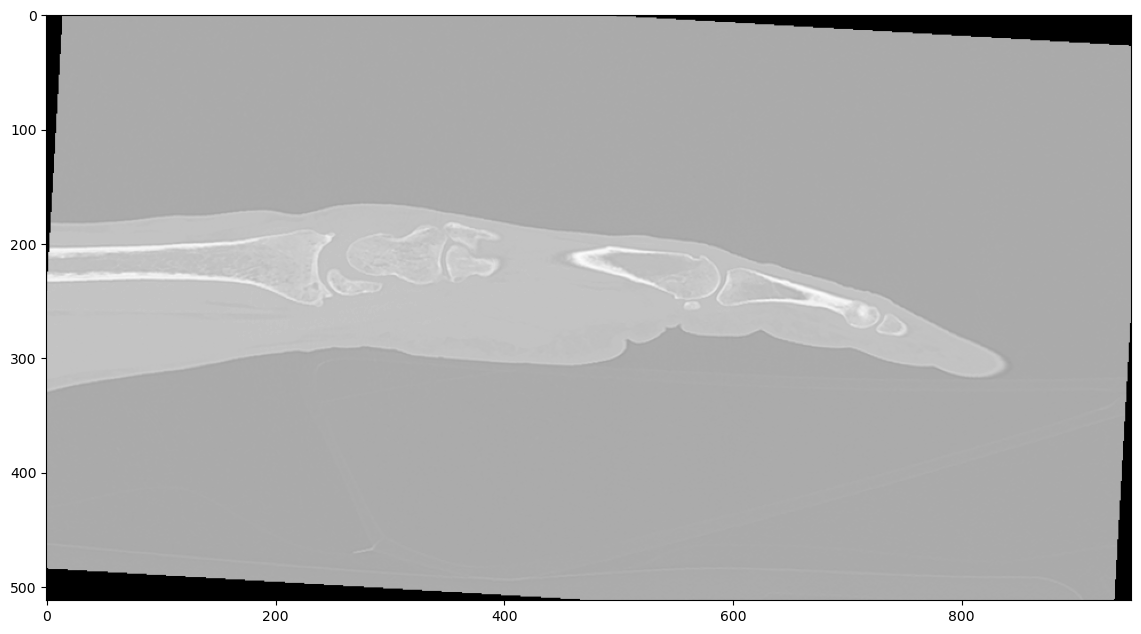

In [40]:
image = tifffile.imread('06_projection_xrr442.tiff')
plt.figure(figsize=(14, 14))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">9.2 Определение на ветикальном сечении проекции "projection_yrr" Side Projection координату последующего сечения Z плоскостью</h4>

In [41]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('06_projection_xrr442.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=30, contrast=500)

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (141, 216)


<h4 style="color:Navy;">9.3 Сечение массива второго поворота "twice_rotated_volume152" плоскостью на высоте 216 с вариантами</h4>

In [42]:
twice_rotated_volume442.shape

(512, 512, 949)

In [43]:
voll = np.transpose(twice_rotated_volume442, (0, 1, 2))
voll.shape

(512, 512, 949)

In [44]:
pictt4 = twice_rotated_volume442[214]
# Зеркальное отражение изображения слева направо
flipped_pictt4 = np.flip(pictt4, axis=0)
flipped_pictt44 = np.transpose(flipped_pictt4, (1, 0))

In [45]:
pictt5 = twice_rotated_volume442[216]
# Зеркальное отражение изображения слева направо
flipped_pictt5 = np.flip(pictt5, axis=0)
flipped_pictt55 = np.transpose(flipped_pictt5, (1, 0))

In [46]:
pictt6 = twice_rotated_volume442[218]
# Зеркальное отражение изображения слева направо
flipped_pictt6 = np.flip(pictt6, axis=0)
flipped_pictt66 = np.transpose(flipped_pictt6, (1, 0))

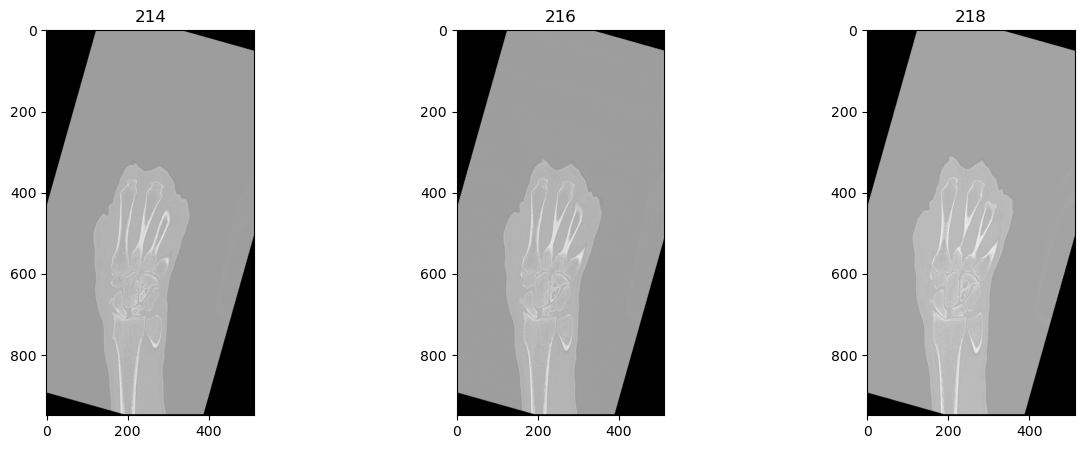

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(flipped_pictt44, cmap='gray')
axs[0].set_title('214')

axs[1].imshow(flipped_pictt55, cmap='gray')
axs[1].set_title('216')

axs[2].imshow(flipped_pictt66, cmap='gray')
axs[2].set_title('218')

plt.show()

<h4 style="color:DarkSlateGray;">9.4 Обрезка изображения для черно-белого изображения</h4>

In [48]:
tifffile.imwrite('15_214_442.tiff', flipped_pictt44) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_216_442.tiff', flipped_pictt55) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_218_442.tiff', flipped_pictt66) # Сохранение массива в TIFF-файл

#### 214

In [49]:
image = Image.open('15_214_442.tiff')

# размеры для обрезки
left = 125
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_214_442_bw.tiff')

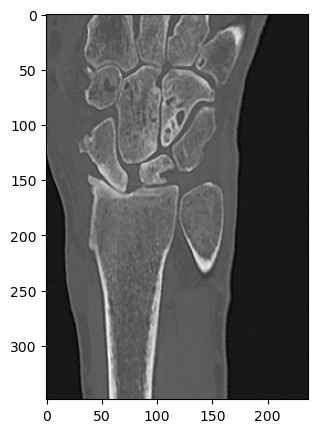

In [50]:
%matplotlib inline
gray_image152 = Image.open('16_214_442_bw.tiff')

plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

#### 216

In [51]:
image = Image.open('15_216_442.tiff')

# размеры для обрезки
left = 125
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_216_442_bw.tiff')

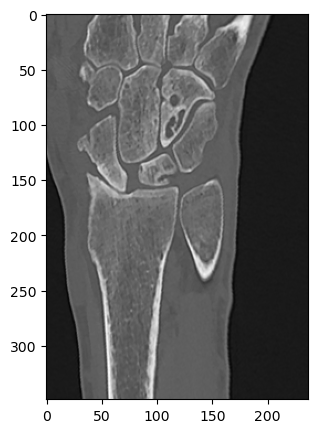

In [52]:
%matplotlib inline
gray_image152 = Image.open('16_216_442_bw.tiff')

plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

#### 218

In [53]:
image = Image.open('15_218_442.tiff')

# размеры для обрезки
left = 125
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_218_442_bw.tiff')

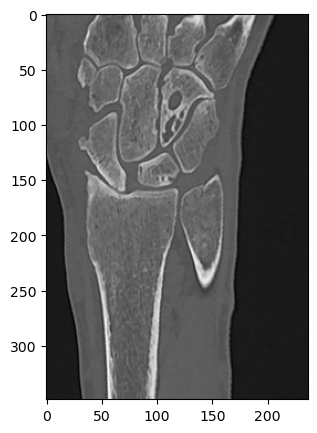

In [54]:
%matplotlib inline
gray_image152 = Image.open('16_218_442_bw.tiff')

plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [55]:
imagettt = tifffile.imread('16_216_442_bw.tiff')

In [56]:
print(imagettt.min())
print(imagettt.max())

6796
10707


In [57]:
# Нормализуем изображение
image_normt = (imagettt - imagettt.min()) / (imagettt.max() - imagettt.min())
image_normt = (image_normt * 255).astype(np.uint8)

# Сохраняем нормализованное изображение в формате PNG
plt.imsave("16_216_442_bw.png", image_normt)

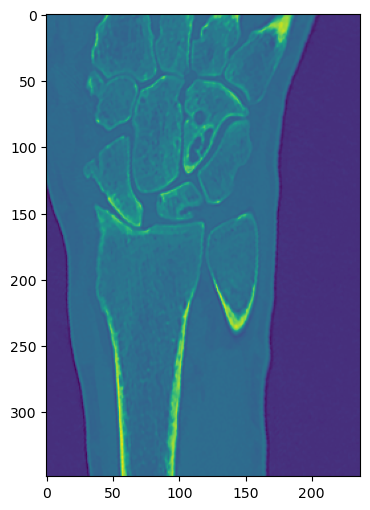

In [58]:
%matplotlib inline
gray_image152 = Image.open('16_216_442_bw.png')

gray_image152 = gray_image152.convert("L")
plt.figure(figsize=(6, 6)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152)#, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">10. "Шарнир"</h2>

In [60]:
import cv2
import numpy as np
from sympy import Point, Circle
plt.figure(figsize=(5, 5))
# Список для хранения координат точек
points = []

# Функция для нанесения точек на изображение
def draw_point(image, point, color, radius=3):
    cv2.circle(image, point, radius, color, -1)

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global points, image
    if event == cv2.EVENT_LBUTTONDOWN:
        # Добавить точку в список
        points.append((x, y))
        
        # Нанести синюю точку
        draw_point(image, (x, y), (255, 0, 0))
        cv2.imshow('Image', image)
        
        # Если было добавлено три точки, вычислить и нанести центр окружности
        if len(points) == 3:
            center = find_circle_center(points[0], points[1], points[2])
            draw_point(image, center, (0, 0, 255))
            cv2.imshow('Image', image)
            
            # Сохранение изображения с нанесёнными точками
            cv2.imwrite('result_16_216_442_bw.png', image)
            print('Изображение сохранено как result_image.jpg')

# Функция для вычисления центра окружности, проходящей через три точки
def find_circle_center(p1, p2, p3):
    c = Circle(Point(p1), Point(p2), Point(p3))
    center = c.center.evalf()
    return (int(center.x), int(center.y))

# Чтение изображения
image = cv2.imread('16_216_442_bw.png')
if image is None:
    raise ValueError('Не удалось загрузить изображение по пути')

# Создание окна и установка обработчика событий мыши
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', mouse_callback)

# Отображение изображения
cv2.imshow('Image', image)
cv2.waitKey(0)
plt.figure(figsize=(15, 15))
cv2.destroyAllWindows()

Изображение сохранено как result_image.jpg


<Figure size 500x500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [61]:
import cv2
import numpy as np
from sympy import Point, Circle

# Список для хранения координат точек
points = []

# Функция для нанесения точек на изображение
def draw_point(image, point, color, radius=3):
    cv2.circle(image, point, radius, color, -1)

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global points, image
    if event == cv2.EVENT_LBUTTONDOWN:
        # Добавить точку в список
        points.append((x, y))
        
        # Нанести синюю точку
        draw_point(image, (x, y), (255, 0, 0))
        cv2.imshow('Image', image)
        
        # Если было добавлено три точки, вычислить и нанести центр окружности
        if len(points) == 3:
            center = find_circle_center(points[0], points[1], points[2])
            draw_point(image, center, (0, 0, 255))
            cv2.imshow('Image', image)
            
            # Сохранение изображения с нанесёнными точками
            cv2.imwrite('2result_16_216_442_bw.png', image)
            print('Изображение сохранено как result_image.jpg')

# Функция для вычисления центра окружности, проходящей через три точки
def find_circle_center(p1, p2, p3):
    c = Circle(Point(p1), Point(p2), Point(p3))
    center = c.center.evalf()
    return (int(center.x), int(center.y))

# Чтение изображения
image = cv2.imread('result_16_216_442_bw.png')
if image is None:
    raise ValueError('Не удалось загрузить изображение по пути')

# Создание окна и установка обработчика событий мыши
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', mouse_callback)

# Отображение изображения

cv2.imshow('Image', image)
plt.figure(figsize=(5, 5))
cv2.waitKey(0)
cv2.destroyAllWindows()

Изображение сохранено как result_image.jpg


<Figure size 500x500 with 0 Axes>

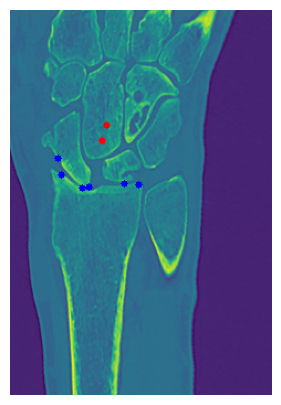

In [62]:
plt.figure(figsize=(5, 5))
%matplotlib inline
gray_image542 = Image.open('2result_16_216_442_bw.png')

# Преобразование изображения в черно-белый формат
#gray_image152 = gray_image152.convert("L")

plt.imshow(gray_image542, cmap='gray') #
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h2 style="color:Navy;">11. Лучевая</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

df44 = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '16_216_442_bw.png'  # Путь к изображению
image = Image.open(image_path).convert("RGBA")

# Конвертируем изображение в массив numpy для отображения через matplotlib
image_array = np.array(image)

# Создаем список для хранения точек
points = []

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=3)
        fig.canvas.draw()
        
        # Когда было выбрано 41 точек или больше, нарисовать кривую линию
        if len(points) == 41:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_internal_pixels_list(points)  # Сначала сохраним изображение, затем пиксели
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.5)  # Рисование линии
    fig.canvas.draw()
    
     # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=2)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("16_216_442_bw_and_line.png")
    print("Изображение сохранено как 16_216_442_bw_and_line.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points):
    mask = Image.new("L", image.size, 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    df44.loc[len(df44)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(df44)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Изображение сохранено как 16_216_442_bw_and_line.png
Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [[32, 165, 133, 255], [35, 168, 131, 255], [30...


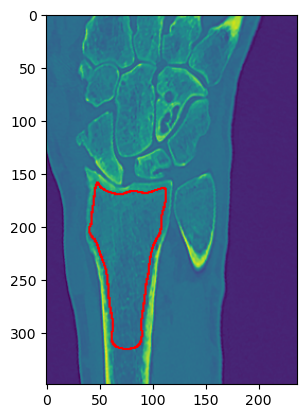

In [3]:
%matplotlib inline
image70 = Image.open('16_216_442_bw_and_line.png')
plt.imshow(image70)#, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:blue;">Количество и значения пикселей на ограниченном линией участке</h4>

In [4]:
# Каличество пикселей
len(df44.iloc[0,0])

6654

In [5]:
# значения пикселя по каналам
c44 = df44.iloc[0,0]
c44[0]

[32, 165, 133, 255]

In [6]:
# КРАСНЫЙ СПИСОК
listic44R = [sublist[0] for sublist in c44]  # Список первых элементов
print(listic44R[0:10])
print(min(listic44R))
print(max(listic44R))

[32, 35, 30, 33, 35, 30, 31, 30, 30, 30]
30
53


In [7]:
# ЗЕЛЁНЫЙ СПИСОК
listic44G = [sublist[1] for sublist in c44]  # Список первых элементов
print(listic44G[0:10])
print(min(listic44G))
print(max(listic44G))

[165, 168, 160, 166, 168, 157, 146, 158, 158, 153]
93
173


In [8]:
# СИНИЙ СПИСОК
listic44B = [sublist[2] for sublist in c44]  # Список первых элементов
print(listic44B[0:10])
print(min(listic44B))
print(max(listic44B))

[133, 131, 135, 133, 131, 136, 140, 136, 136, 138]
128
142


In [9]:
import pickle
with open('listic44R.pkl', 'wb') as f:
    pickle.dump(listic44R, f)
with open('listic44G.pkl', 'wb') as f:
    pickle.dump(listic44G, f)
with open('listic44B.pkl', 'wb') as f:
    pickle.dump(listic44B, f)


In [10]:
import pickle
# Загрузка из pickle-файла
with open('listic44R.pkl', 'rb') as f:
    listic44R = pickle.load(f)
# Загрузка из pickle-файла
with open('listic44G.pkl', 'rb') as f:
    listic44G = pickle.load(f)
# Загрузка из pickle-файла
with open('listic44B.pkl', 'rb') as f:
    listic44B = pickle.load(f)


<h2 style="color:Blue;">12. Представление распределения вырезанной части изображения unhealthy</h2>

<h4 style="color:Blue;">12.1 Представление распределения вырезанной части изображения суммарно listic44R + listic44G</h4>

In [24]:
listic44RG = listic44R + listic44G 

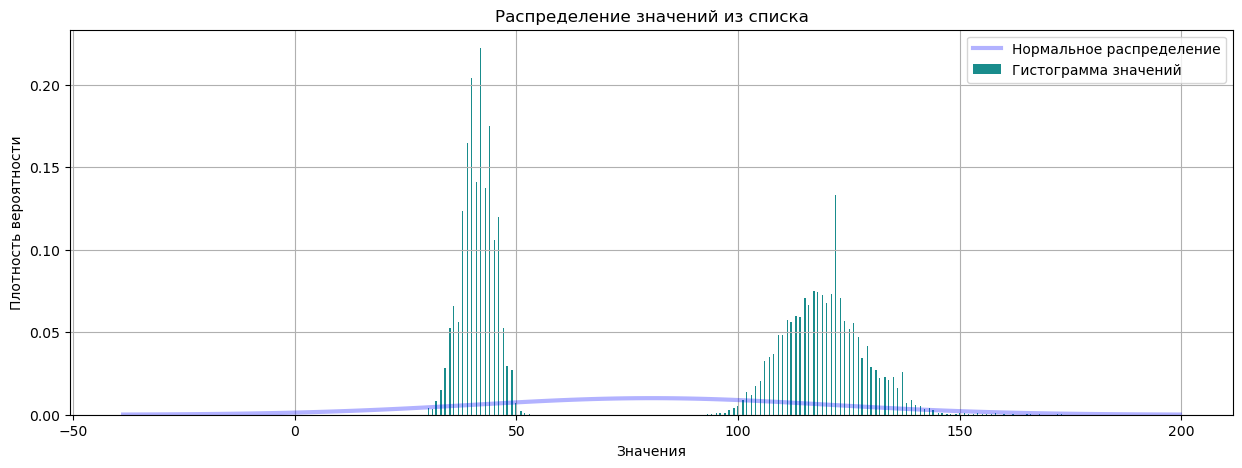

Эксцесс  -1.863339054073359
Асимметрия  0.06982289582920756
Среднее значение пикселей: 80.46889089269612
Минимальное значение пикселей: 30
Минимальное значение пикселей: 173
Три наиболее часто встречающихся значения:
Значение: 42, Частота: 846
Значение: 40, Частота: 778
Значение: 44, Частота: 666


In [25]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic44RG) ######################################################################
std_dev = np.std(listic44RG) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic44RG, density=True, bins=500, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic44RG))######################################################
print("Асимметрия ", skew(listic44RG))####################################################

average = statistics.mean(listic44RG) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic44RG)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic44RG)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic44RG)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">12.2 Представление распределения вырезанной части изображения listic44R</h4>

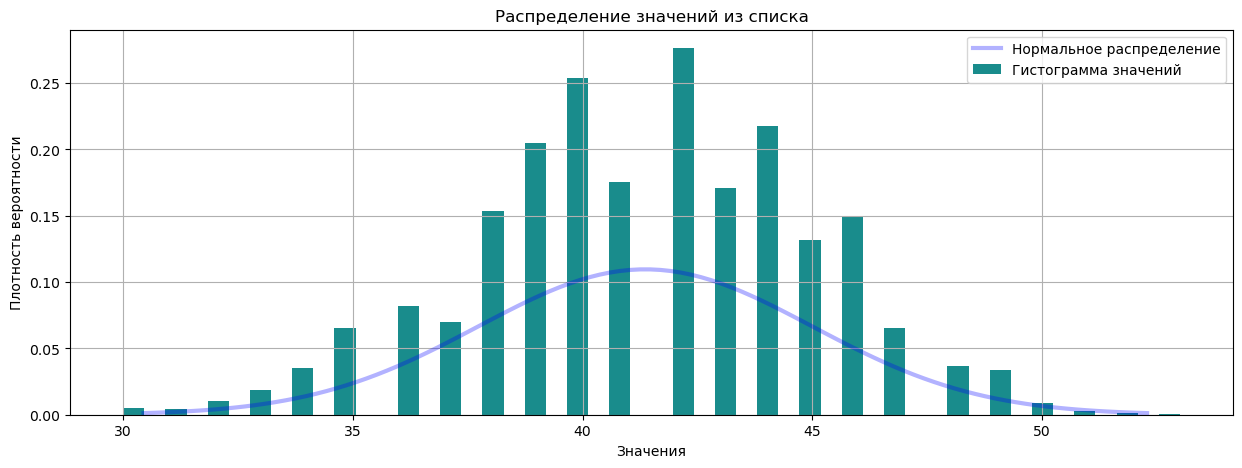

Эксцесс  -0.1410265927194394
Асимметрия  -0.16072646096318072
Среднее значение пикселей: 41.36414186955215
Минимальное значение пикселей: 30
Максимальное значение пикселей: 53
Три наиболее часто встречающихся значения:
Значение: 42, Частота: 846
Значение: 40, Частота: 778
Значение: 44, Частота: 666


In [28]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic44R) ######################################################################
std_dev = np.std(listic44R) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic44R, density=True, bins=50, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic44R))######################################################
print("Асимметрия ", skew(listic44R))####################################################

average = statistics.mean(listic44R) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic44R)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic44R)###################################################################
print(f'Максимальное значение пикселей: {ma}') 

count = Counter(listic44R)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (healthy)</h4>

Отношение объема пересечения к объему объединения: 0.6870888811988806


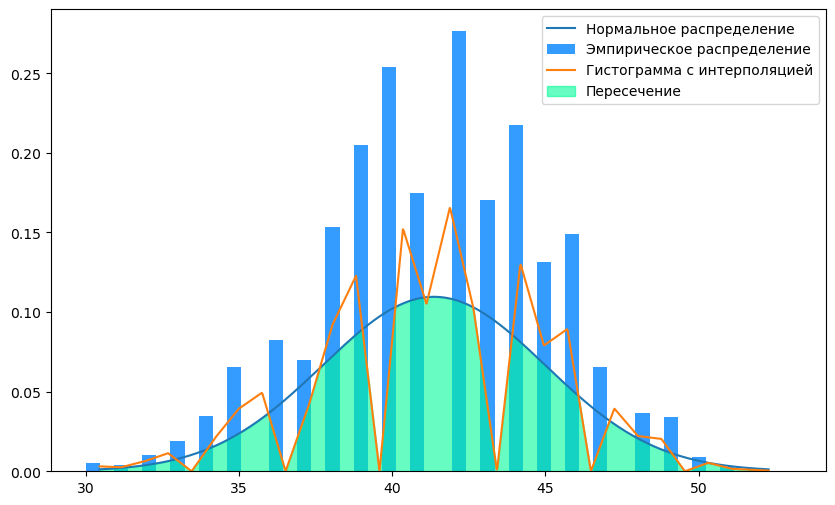

In [31]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic44R)
std_dev = np.std(listic44R)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic44R, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic44R, bins=50, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h4 style="color:Blue;">Пересечение гистограммы 44 с 15</h4>

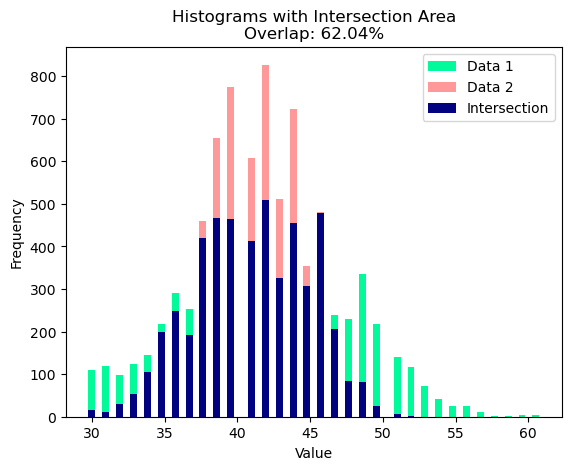

In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic15R
data2 = listic44R

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 65

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.99, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='red', alpha=0.4, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.99, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

<h4 style="color:Blue;">12.3 Представление распределения вырезанной части изображения listic44G</h4>

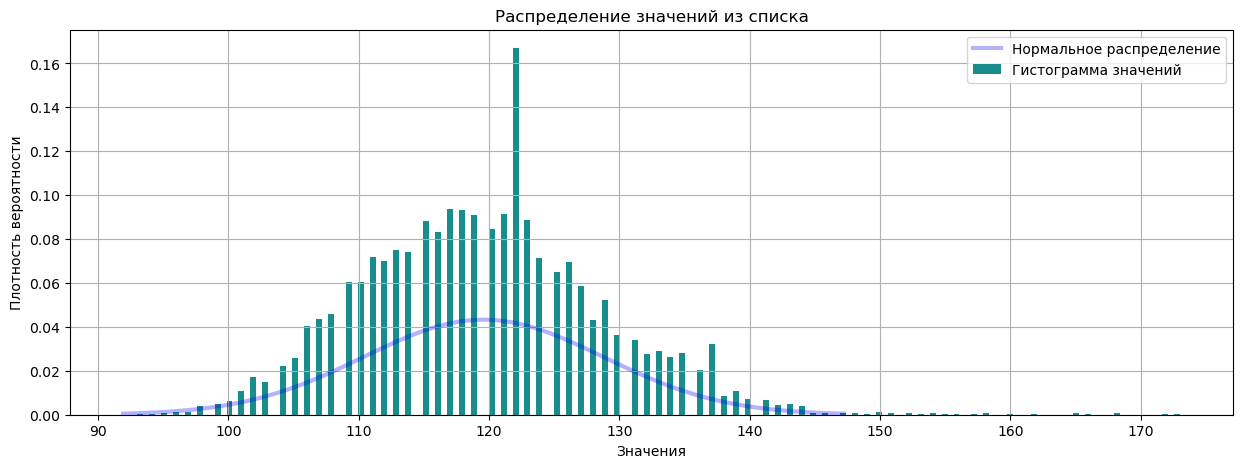

Эксцесс  0.9050372080839337
Асимметрия  0.4500150323375134
Среднее значение пикселей: 119.57363991584009
Минимальное значение пикселей: 93
Максимальное значение пикселей: 173
Три наиболее часто встречающихся значения:
Значение: 122, Частота: 508
Значение: 117, Частота: 285
Значение: 118, Частота: 284


In [41]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic44G) ######################################################################
std_dev = np.std(listic44G) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic44G, density=True, bins=175, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic44G))######################################################
print("Асимметрия ", skew(listic44G))####################################################

average = statistics.mean(listic44G) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic44G)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic44G)###################################################################
print(f'Максимальное значение пикселей: {ma}') 

count = Counter(listic44G)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (healthy)</h4>

Отношение объема пересечения к объему объединения: 0.8459227761004212


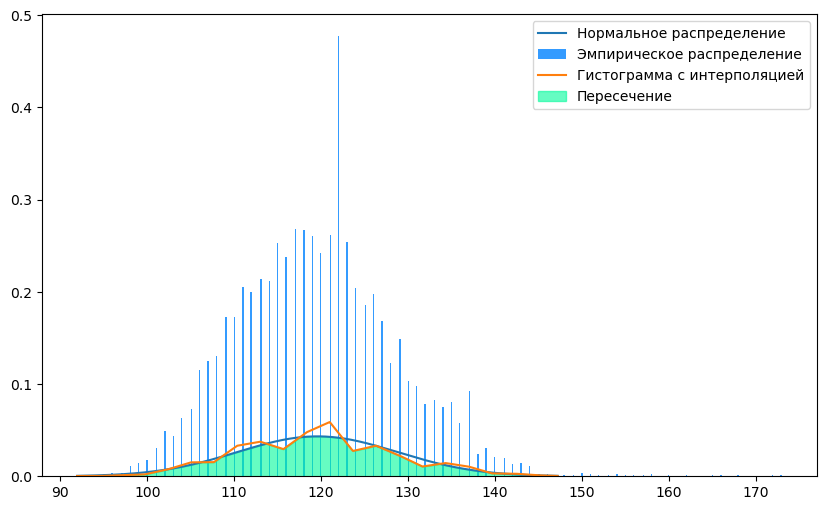

In [42]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic44G)
std_dev = np.std(listic44G)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic44G, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic44G, bins=500, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h4 style="color:Blue;">Пересечение гистограммы 44 с 15</h4>

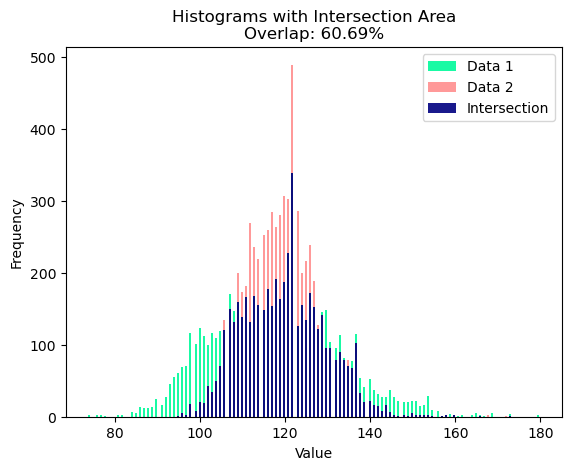

<Figure size 1000x600 with 0 Axes>

In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic15G
data2 = listic44G

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 225

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='red', alpha=0.4, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.9, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

In [ ]:
<h4 style="color:Blue;">12.4 Представление распределения вырезанной части изображения listic44B</h4>

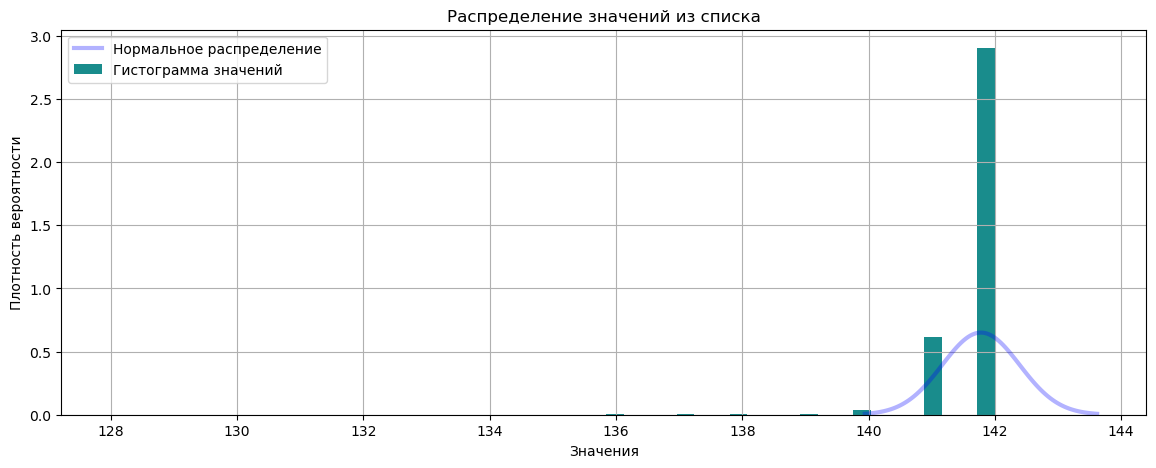

Эксцесс  128.16854520845612
Асимметрия  -8.300713900972472
Среднее значение пикселей: 41.36414186955215
Минимальное значение пикселей: 128
Максимальное значение пикселей: 142
Три наиболее часто встречающихся значения:
Значение: 142, Частота: 5412
Значение: 141, Частота: 1140
Значение: 140, Частота: 69


In [46]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic44B) ######################################################################
std_dev = np.std(listic44B) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(14, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic44B, density=True, bins=50, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic44B))######################################################
print("Асимметрия ", skew(listic44B))####################################################

average = statistics.mean(listic44R) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic44B)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic44B)###################################################################
print(f'Максимальное значение пикселей: {ma}') 

count = Counter(listic44B)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (unhealthy)</h4>

Отношение объема пересечения к объему объединения: 0.22169396160734062


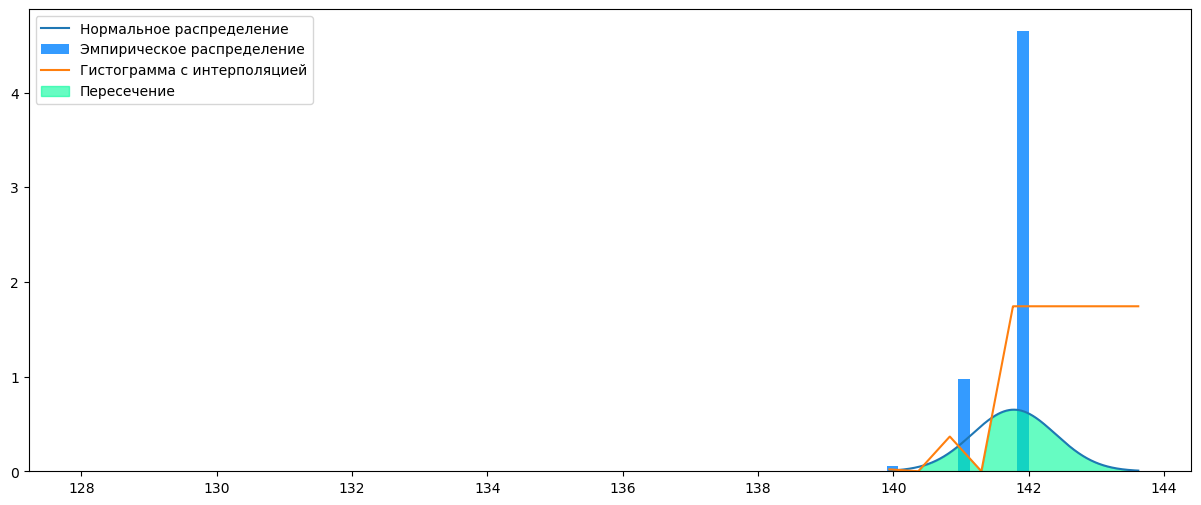

In [64]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic44B)
std_dev = np.std(listic44B)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic44B, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(15, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic44B, bins=80, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h4 style="color:Blue;">Пересечение гистограммы 44 с 15</h4>

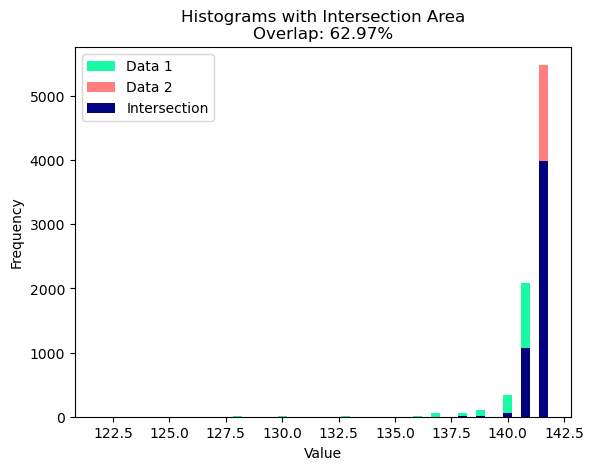

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic15B
data2 = listic44B

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 50

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='red', alpha=0.5, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.99, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

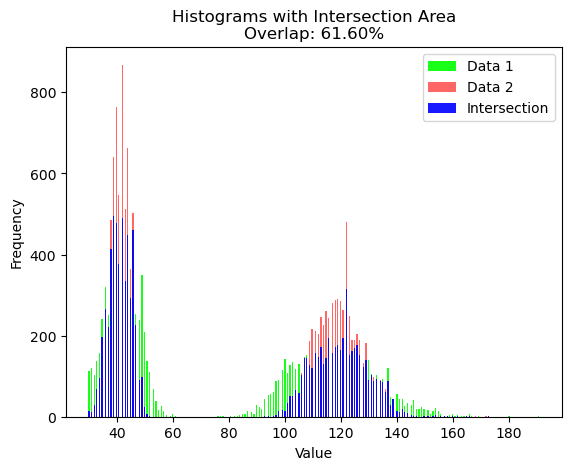

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic15RG
data2 = listic44RG

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 350

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()#figsize=(6, 2.5), dpi=300)#, tight_layout=True)

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='Lime', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='Red', alpha=0.6, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Blue', alpha=0.9, label='Intersection')

# Легенда и подписи
ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()